<h1><span style='color:#8E5609;background:white'> IP Address Analysis - Team Cymru</span></h1>

---
## Load Data Set

In [1]:
import os
import ipaddress
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from datetime import date, datetime
import dns.query, dns.message, dns.reversename, dns.resolver

# Seaborn / Matplotlib Settings
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# This is our enriched TeamCymru Data Set
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
# We want to set the ASN datatype to object so its isn't interpreted as an int
df_tc = pd.read_csv("../data_sets/download/src_ip_failed_login_attempts_team_cymru_ip_to_asn_mapped.csv",header=0,dtype={'ASN': object})

---
## Review Data Set

In [2]:
df_tc.head(10)

ip_count           src_ip     ASN        BGP Prefix Country Code      RIR   
0         1     102.91.5.112   29465     102.91.5.0/24           NG  afrinic  \
1         1     103.100.4.46  132116    103.100.4.0/24           IN    apnic   
2         1  103.155.210.207  133007  103.155.210.0/24           IN    apnic   
3         1     103.39.30.30  134866    103.39.30.0/24           IN    apnic   
4         1    103.86.19.113   45916    103.86.19.0/24           IN    apnic   
5         1     104.5.71.254    7018      104.0.0.0/12           US     arin   
6         1   106.204.132.70   45609  106.204.128.0/18           IN    apnic   
7         1  106.204.152.180   45609  106.204.128.0/18           IN    apnic   
8         1   106.205.159.99   45609  106.205.128.0/18           IN    apnic   
9         1    106.205.236.6   45609  106.205.224.0/20           IN    apnic   

  Allocation Date                                     AS Description   
0      2018-09-04                                         VCG-AS, NG  \
1      2017-08-31              ANINETWORK-IN Ani Network Pvt Ltd, IN   
2      2020-09-16              UCN-AS UCN CABLE NETWORK PVT. LTD, IN   
3      2014-09-16                           SSCN-AS Sscn Pvt Ltd, IN   
4      2017-02-16            GTPL-AS-AP Gujarat Telelink Pvt Ltd, IN   
5      2014-01-16                                  ATT-INTERNET4, US   
6      2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...   
7      2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...   
8      2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...   
9      2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...   

                        AS Peers  
0                          16637  
1                           9498  
2                          17762  
3                         136334  
4                     4755 55836  
5  1239 1299 2914 3257 3356 6939  
6                           9498  
7                           9498  
8                           9498  
9                           9498

### Convert RIR values to uppercase.
* Merge to enrichment script

In [3]:
# Set RIR value to upper case
df_tc['RIR'] = df_tc['RIR'].str.upper()

### Add IP address protocol version
- Backport into enrichment script

### Describe

- Generate descriptive statistics.
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

### Observation(s)

This data is useful as it provides insight into starting values we could filter on initially for number of times a src_ip was seen during a login.  In this instance we can see that 50% of the src_ip's attempting to login did so (9) times. In this case the 25% value is fairly high.



In [4]:
df_tc.describe()

ip_count
count  1948.000000
mean     16.690965
std      18.956197
min       1.000000
25%       3.000000
50%       9.000000
75%      25.000000
max     172.000000

---

### Nunique

- Count number of distinct elements in specified axis.
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html

### Observation(s)

- Confirm that the src_ip matches the number of entries as this data set has provided an an aggregate count.
- We can see that for **1948** entries there are **248** unique ASN's
- There are only (5) RIR's the 6th comes from the NaN entries as they haven't been dropped.
- There are only **207** unique peering arrangements. This can be misleading however since the AS Peer number ordering is most likely being treated as a unique string.

In [5]:
df_tc.nunique()

ip_count             82
src_ip             1948
ASN                 247
BGP Prefix         1029
Country Code         37
RIR                   5
Allocation Date     356
AS Description      246
AS Peers            205
dtype: int64

### Check NaN Values

In [6]:
df_tc.isna().sum()

ip_count            0
src_ip              0
ASN                11
BGP Prefix         11
Country Code       12
RIR                11
Allocation Date    12
AS Description     11
AS Peers           11
dtype: int64

### If there are NaN values check the lookup
* Lookup tool - https://asn.cymru.com/

In [7]:
df_tc[df_tc.isna().any(axis=1)]

ip_count                                   src_ip    ASN   
336          2                             1.38.152.142    NaN  \
384          2  2402:3a80:1529:922a:301a:3ee1:7bfb:4eff    NaN   
385          2       2402:3a80:160c:dedd:0:10:273d:e201    NaN   
530          3  2402:3a80:1a26:8fce:ecb2:a83b:1aa6:3bee    NaN   
612          4                            106.76.75.120    NaN   
707          5                           114.31.152.118    NaN   
822          6   2402:3a80:1a24:9db5:cf0:7c9f:ed22:9a04    NaN   
878          7   2402:3a80:19a6:b963:c923:2b27:dc9:7344    NaN   
1346        19           2402:3a80:1f22:fc69::1da7:bd15    NaN   
1677        42                            162.247.24.22  14434   
1735        47                          111.119.214.186    NaN   
1945        89                            103.200.74.23    NaN   

           BGP Prefix Country Code   RIR Allocation Date AS Description   
336               NaN          NaN   NaN             NaN            NaN  \
384               NaN          NaN   NaN             NaN            NaN   
385               NaN          NaN   NaN             NaN            NaN   
530               NaN          NaN   NaN             NaN            NaN   
612               NaN          NaN   NaN             NaN            NaN   
707               NaN          NaN   NaN             NaN            NaN   
822               NaN          NaN   NaN             NaN            NaN   
878               NaN          NaN   NaN             NaN            NaN   
1346              NaN          NaN   NaN             NaN            NaN   
1677  162.247.24.0/21          NaN  ARIN             NaN    VIPNAS1, VI   
1735              NaN          NaN   NaN             NaN            NaN   
1945              NaN          NaN   NaN             NaN            NaN   

     AS Peers  
336       NaN  
384       NaN  
385       NaN  
530       NaN  
612       NaN  
707       NaN  
822       NaN  
878       NaN  
1346      NaN  
1677   394680  
1735      NaN  
1945      NaN

---
## Analyze Data Set

### 1. Source IP Addresses Distributed by RIR

* Regional Internet Registries(RIR) are delegated IP address prefixes and AS number spaces from Internet Assigned Numbers Authority(IANA)
* Observing this metric gives us situational information in our exploration of the data set.


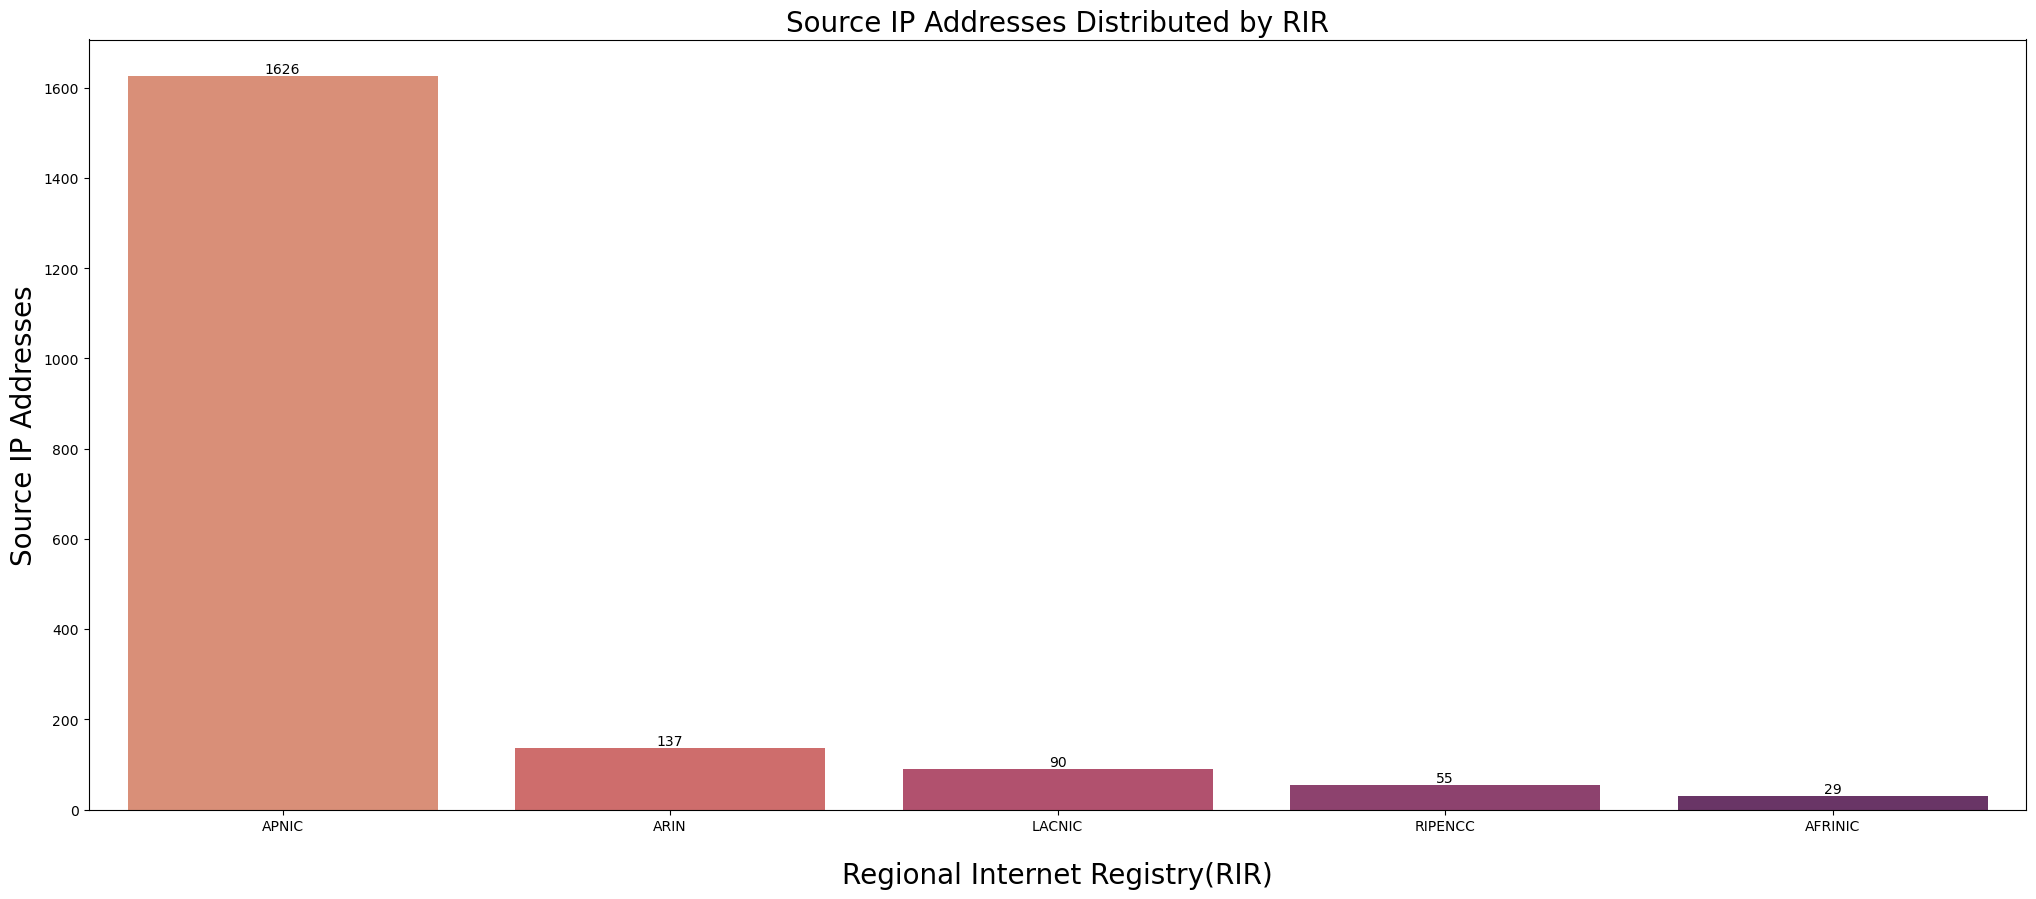

In [8]:
fig, ax = plt.subplots(figsize=(25,10))
sns.countplot(x='RIR',data=df_tc, order=df_tc.RIR.value_counts().index, palette="flare", ax=ax, lw=1)
ax.set_title("Source IP Addresses Distributed by RIR", fontsize=20) 
ax.set_xlabel("Regional Internet Registry(RIR)", fontsize=20, labelpad=20)
ax.set_ylabel("Source IP Addresses", fontsize=20)

# Loop through index to provide values to place at the top
# of the bars. Use count to provide graph locations for 
# ax.text
count = 0

for rir, v in df_tc.RIR.value_counts().items():
    ax.text(count,v,v, ha="center", va="bottom")
    count = count+1

### Observations

1. APNIC has the highest number of source IP addresses compared to the other RIR's.
2. We have some IP address entries that are missing information, these could be spoofed.
3. Searching for these IP address prefixes online may determine other information.

---

### 2. Source IP Addresses Distributed by ASN

* We want to look at the distribution of source IP addresses entries from their assigned Autonomous System Number(ASN). 
* ASN's are assigned via RIR's and represent an organizations collective IP address prefixes.
* ASN allow for multi-homing (multiple ISP transit providers) and control over how network prefixes are presented and routed to on the Internet.
* Usually this allows you to have a starting point to report network abuse as its tied to a business owner.

ASN Resources

* https://datatracker.ietf.org/doc/rfc1930
* https://datatracker.ietf.org/doc/rfc5396
* https://datatracker.ietf.org/doc/rfc6793


In [9]:
# Group by ASN and RIR with counts.
# Drop the other rows here as part of this temp processing.
df_tc_asn = df_tc.drop(columns=["src_ip","BGP Prefix","Country Code","Allocation Date","AS Peers"])

df_arin = df_tc_asn.groupby('RIR').get_group('ARIN')
df_apnic = df_tc_asn.groupby('RIR').get_group('APNIC')
df_ripencc = df_tc_asn.groupby('RIR').get_group('RIPENCC')
df_lacnic = df_tc_asn.groupby('RIR').get_group('LACNIC')
df_afrinic = df_tc_asn.groupby('RIR').get_group('AFRINIC')

In [10]:
# Set the bar label to the value count of unique IP addresses per ASN
def bar_label_text(_rir_df, _axes_val):
    '''
    Parameters
    ----------
    
    _rir_df:
        This is the specific group-by data-frame(df) for the specific RIR. This 
        reduces the amount of data that needs to be passed to the function for
        processing.
        
    _axes_val:
        We are sub-plotting one graph for each RIR, (5) in total, within a single 
        figure. This values defines the subplot that we current want to process.
        
    Returns
    -------
    
    There are no return values as this is setting the respective 'axs[x]' values.
    
    Notes
    -----
    
    We pass in the RIR data-frame that has the ASN and its total unique IP address
    count. We unpack the ASN and its value count to determine the needed (x,y)
    coordinate values and the value text to be printed. 
    
    An example:
    
    [[ASN, Unique IP Address Value Count],[ASN, Unique IP Address Value Count],..]
    [[1234,15],[5689,67],...]]
    
    Following the Axes.text inputs:
    
    https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html#matplotlib.axes.Axes.text
    
    Our X value will be the index location of [1234,15] and our Y location will be the value for the ASN entry which is (15). 
    We want to print the unique IP address count value as our text, S. This also happens to be the same data that is unpacked
    into variable V. 
    
    A single entry would look like this:
    
    axs[_axes_val].text(0,15,str(15), ha="center", va="bottom"
    axs[_axes_val].text(1,67,str(67), ha="center", va="bottom"
    '''
    
    for asn, v in _rir_df.ASN.value_counts().items():
        axs[_axes_val].text(_rir_df.ASN.value_counts().index.get_indexer([asn]),v,str(v), ha="center", va="bottom", fontstyle='italic', fontsize='15')

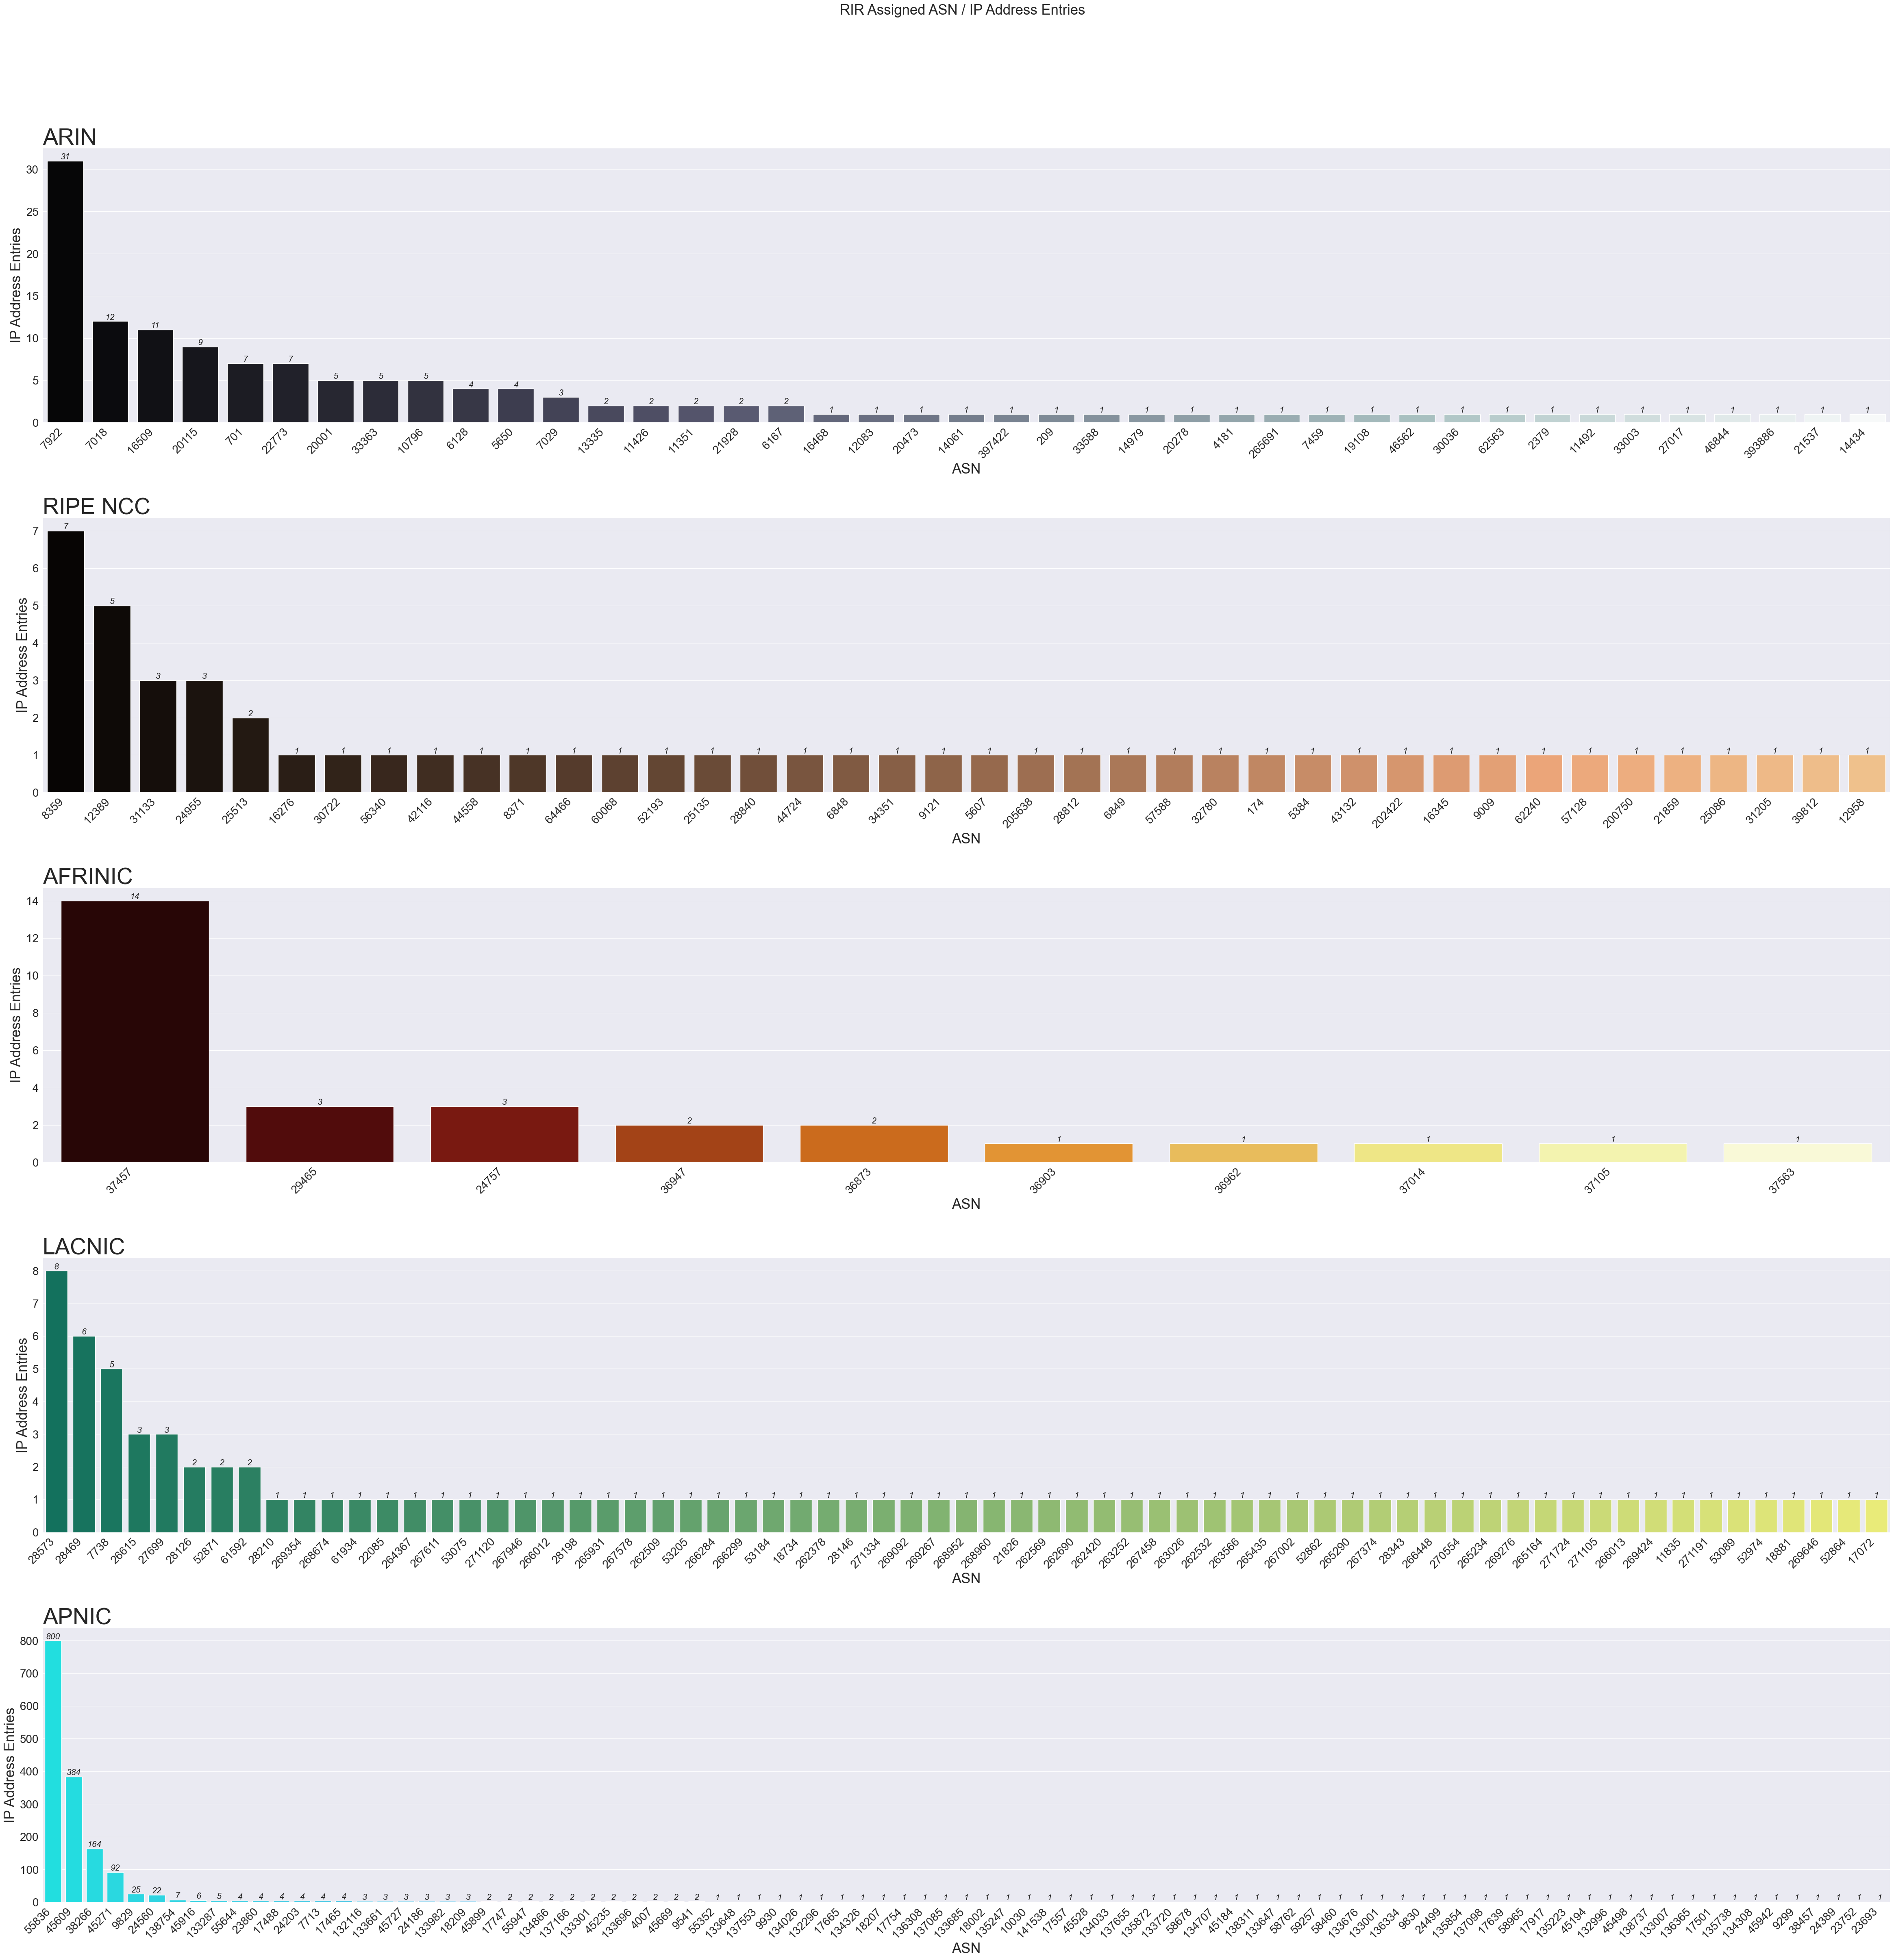

In [11]:
# Graph the results
sns.set_style("darkgrid")

f, axs = plt.subplots(5,1,figsize=(50,50))
f.suptitle('RIR Assigned ASN / IP Address Entries', fontsize=25)
f.tight_layout(pad=15.0)


# ARIN
sns.countplot(x='ASN', data=df_arin, order=df_arin.ASN.value_counts().index, ax=axs[0], palette="bone")
axs[0].set_title('ARIN', fontsize=40, loc='left',)
axs[0].set_xlabel("ASN", fontsize=25)
axs[0].set_ylabel("IP Address Entries", fontsize=25)
axs[0].tick_params(labelsize=20)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_arin, 0)


# RIPE
sns.countplot(x='ASN', data=df_ripencc, order=df_ripencc.ASN.value_counts().index, ax=axs[1], palette="copper")
axs[1].set_title('RIPE NCC', fontsize=40, loc='left')
axs[1].set_xlabel("ASN", fontsize=25)
axs[1].set_ylabel("IP Address Entries", fontsize=25)
axs[1].tick_params(labelsize=20)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_ripencc, 1)


# Afrinic
sns.countplot(x='ASN', data=df_afrinic, order=df_afrinic.ASN.value_counts().index, ax=axs[2], palette="afmhot")
axs[2].set_title('AFRINIC', fontsize=40, loc='left')
axs[2].set_xlabel("ASN", fontsize=25)
axs[2].set_ylabel("IP Address Entries", fontsize=25)
axs[2].tick_params(labelsize=20)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_afrinic, 2)


# Lacnic
sns.countplot(x='ASN', data=df_lacnic, order=df_lacnic.ASN.value_counts().index, ax=axs[3], palette="summer")
axs[3].set_title('LACNIC', fontsize=40, loc='left')
axs[3].set_xlabel("ASN", fontsize=25)
axs[3].set_ylabel("IP Address Entries", fontsize=25)
axs[3].tick_params(labelsize=20)
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_lacnic, 3)


# Apnic
sns.countplot(x='ASN', data=df_apnic, order=df_apnic.ASN.value_counts().index, ax=axs[4], palette="cool")
axs[4].set_title('APNIC', fontsize=40, loc='left')
axs[4].set_xlabel("ASN", fontsize=25)
axs[4].set_ylabel("IP Address Entries", fontsize=25)
axs[4].tick_params(labelsize=20)
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=45, horizontalalignment='right')

# Call function to add bar label of unique IP address count to top of bar.
bar_label_text(df_apnic, 4)


#plt.legend()
plt.show()

### Observations

* We see that ASN's within the APNIC region have the highest number of source IP addresses.
  * 55836
  * 45609
  * 38266
  * 45271
  * 9829
  * 24560
* This matches with our initial source IP address RIR distribution above.

**Improvement**
* Add an additional function to capture a dictionary of RIR:[{ASN:Count,ASN:Count}]>1

---

### 3. Source IP Address Connection Counts by RIR

- The above analysis looks at the number of source IP address rows distributed by RIR and ASN. 
- Those entries do not represent the cumulative times that the source IP address attempted a connection.

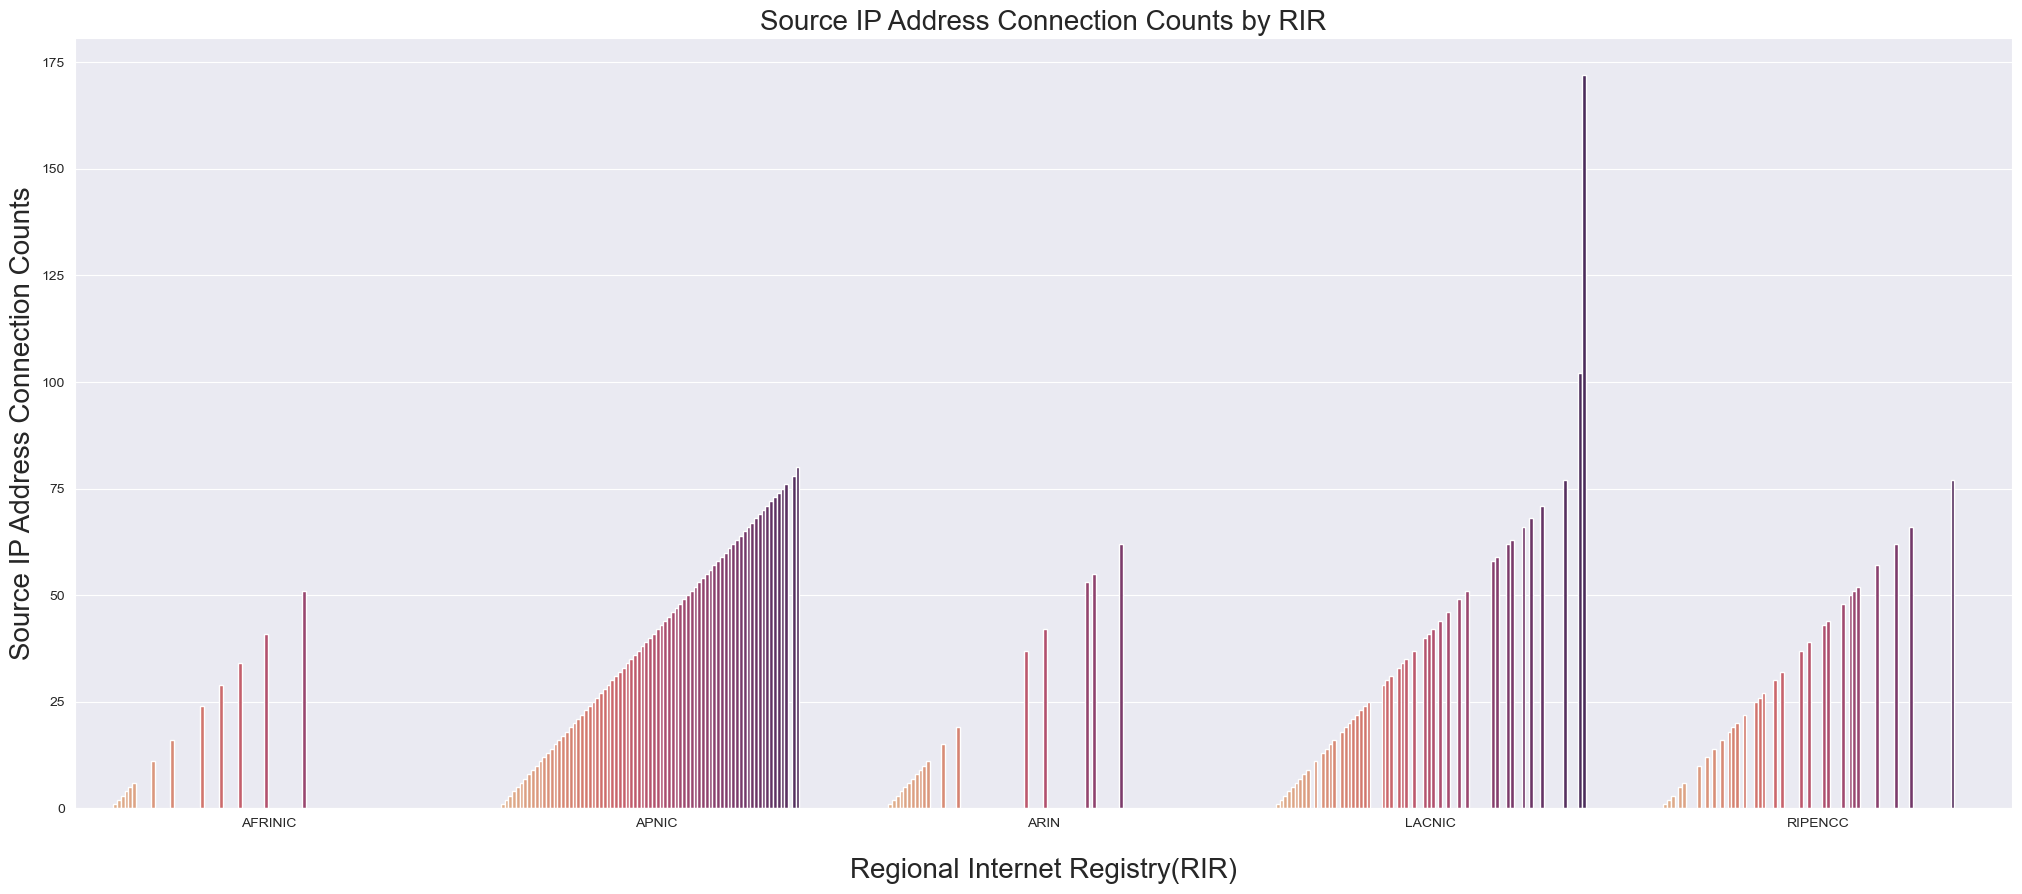

In [12]:
fig, ax = plt.subplots(figsize=(25,10))
sns.barplot(x='RIR',y="ip_count", data=df_tc, hue='ip_count', palette="flare", ax=ax, lw=1)
ax.set_title("Source IP Address Connection Counts by RIR", fontsize=20) 
ax.set_xlabel("Regional Internet Registry(RIR)", fontsize=20, labelpad=20)
ax.set_ylabel("Source IP Address Connection Counts", fontsize=20)
ax.legend_.remove()


#### Observations

* LACNIC has the (2) highest source IP address connection counts.
* APNIC has steady grouping of source IP address connection counts, along with LACNIC and RIPENCC.
* APNIC doesn't have the highest individual source IP connection counts however it does have a higher quantity of source IP connections.

---

### 4. Cumulative Source IP Count by RIR

* To further confirm the graph above we can see that the top (3) cumulative source IP address counts are
   * APNIC
   * LACNIC
   * RIPENCC


In [13]:
df_rir_count = df_tc.groupby(['RIR'], as_index=False)['ip_count'].sum().reindex()

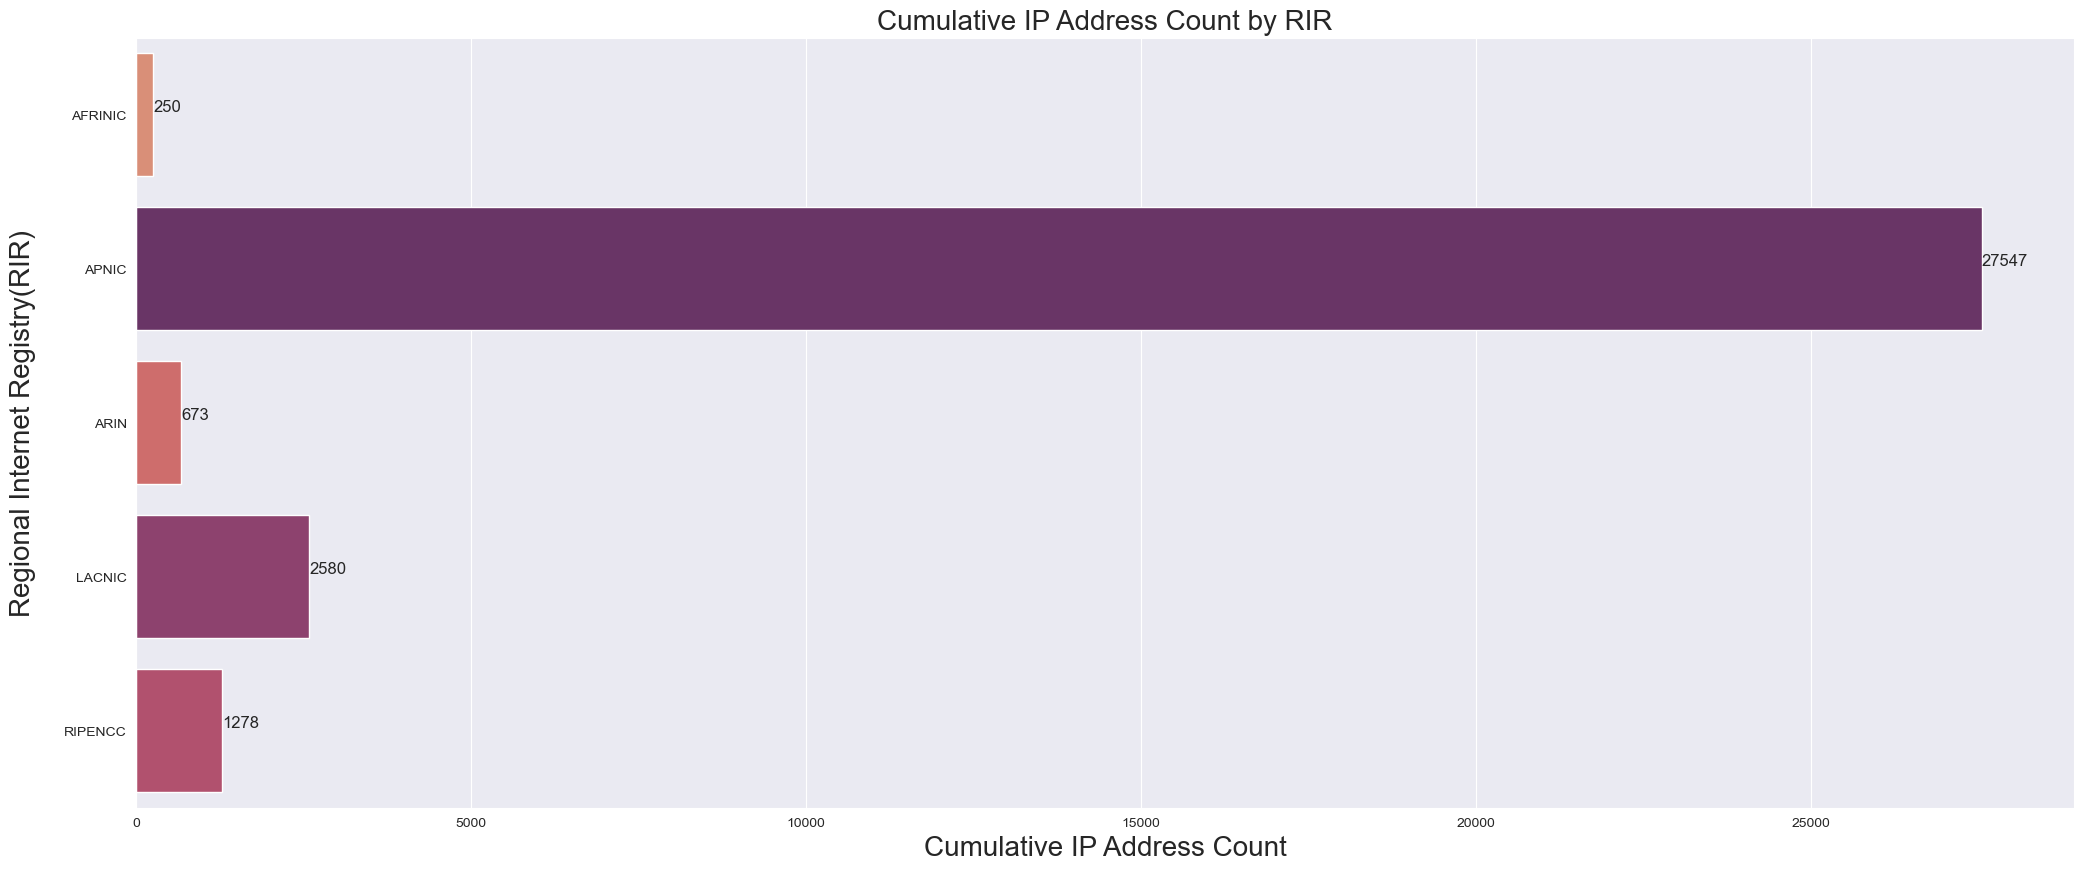

In [14]:
fig, ax = plt.subplots(figsize=(25,10))
sns.barplot(data=df_rir_count, y="RIR", x="ip_count", hue='ip_count', errorbar=None, orient="h", palette="flare", dodge=False, ax=ax, lw=1)
ax.set_title("Cumulative IP Address Count by RIR", fontsize=20) 
ax.set_ylabel("Regional Internet Registry(RIR)", fontsize=20, labelpad=20)
ax.set_xlabel("Cumulative IP Address Count", fontsize=20)
ax.legend_.remove()

# Set Bar Label
count = 0
for rir, v in df_rir_count.values:
    ax.text(v,count,str(v), ha="left", va="bottom", fontstyle='normal', fontsize='12')
    count = count+1

---

### 5. Collection of ASN's by Percentile

#### 25%(<= 3), 50%(= 9), 75% percentile (>= 25) and Interquartile range (>3 & <=25) IP address connection count

* We want to build a dataframe to look at the 25%, 50%, 75% and interquartile percentile of IP connection counts.

In [15]:
# Set AS Peers as list of strings
df_tc['AS Peers'] = df_tc['AS Peers'].str.split()

# Create percentiles
# First Quartile [Lower] (Q1) (ip_count <= 3)
df_25_percentile = df_tc[df_tc.ip_count.le(3)]

# Second Quartile [Median] (Q2) (ip_count = 9)
df_50_percentile = df_tc[(df_tc.ip_count.eq(9))]

# Third Quartile [Upper] (ip_count >= 25)
df_75_percentile = df_tc[df_tc.ip_count.ge(25)]

# Interquartile Range (IQR) (ip_count > 3 & ip_count < 25)
df_iqr_percentile = df_tc[(df_tc.ip_count.gt(3) & df_tc.ip_count.lt(25))]


In [16]:
# Drop NaN values
df_25_percentile = df_25_percentile.dropna()
df_50_percentile = df_50_percentile.dropna()
df_75_percentile = df_75_percentile.dropna()
df_iqr_percentile = df_iqr_percentile.dropna()

# Drop non AS values
df_25_percentile = df_25_percentile.drop(columns=["src_ip","BGP Prefix","Country Code","Allocation Date"])
df_50_percentile = df_50_percentile.drop(columns=["src_ip","BGP Prefix","Country Code","Allocation Date"])
df_75_percentile = df_75_percentile.drop(columns=["src_ip","BGP Prefix","Country Code","Allocation Date"])
df_iqr_percentile = df_iqr_percentile.drop(columns=["src_ip","BGP Prefix","Country Code","Allocation Date"])

# Explode AS Peers
#
# Break out multiple peers into additional row entry since traffic could go across that Peer
# and we want to include it in the mapping. This could skew the ip_count results after this
# as there would be more edge connections for a host with more than one peer, however since 
# we are looking for relationships between the traffic and ASN peers not including them is 
# an incomplete data set.
#
# You can identify exploded values by the repeated index value.

df_25_percentile = df_25_percentile.explode('AS Peers', ignore_index=False)
df_50_percentile = df_50_percentile.explode('AS Peers', ignore_index=False)
df_75_percentile = df_75_percentile.explode('AS Peers', ignore_index=False)
df_iqr_percentile = df_iqr_percentile.explode('AS Peers', ignore_index=False)

In [17]:
df_25_percentile.head()

ip_count     ASN      RIR                           AS Description AS Peers
0         1   29465  AFRINIC                               VCG-AS, NG    16637
1         1  132116    APNIC    ANINETWORK-IN Ani Network Pvt Ltd, IN     9498
2         1  133007    APNIC    UCN-AS UCN CABLE NETWORK PVT. LTD, IN    17762
3         1  134866    APNIC                 SSCN-AS Sscn Pvt Ltd, IN   136334
4         1   45916    APNIC  GTPL-AS-AP Gujarat Telelink Pvt Ltd, IN     4755

In [18]:
df_25_percentile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 927 entries, 0 to 607
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip_count        927 non-null    int64 
 1   ASN             927 non-null    object
 2   RIR             927 non-null    object
 3   AS Description  927 non-null    object
 4   AS Peers        927 non-null    object
dtypes: int64(1), object(4)
memory usage: 43.5+ KB


In [19]:
df_50_percentile.head()

ip_count     ASN    RIR   
970         9  132996  APNIC  \
971         9   45271  APNIC   
972         9   24560  APNIC   
973         9   38266  APNIC   
974         9   17488  APNIC   

                                        AS Description AS Peers  
970     THREESAINFOWAY-AS Threesa Infoway Pvt.Ltd., IN   133296  
971             ICLNET-AS-AP Idea Cellular Limited, IN    55644  
972  AIRTELBROADBAND-AS-AP Bharti Airtel Ltd., Tele...     9498  
973                VODAFONE-IN Vodafone India Ltd., IN    55410  
974  HATHWAY-NET-AP Hathway IP Over Cable Internet, IN    55836

In [20]:
df_50_percentile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 970 to 1021
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip_count        59 non-null     int64 
 1   ASN             59 non-null     object
 2   RIR             59 non-null     object
 3   AS Description  59 non-null     object
 4   AS Peers        59 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.8+ KB


In [21]:
df_75_percentile.head()

ip_count     ASN    RIR   
1446        25  132296  APNIC  \
1447        25   45609  APNIC   
1448        25   45271  APNIC   
1449        25    9829  APNIC   
1449        25    9829  APNIC   

                                         AS Description AS Peers  
1446  SEVENSTARDIGITAL-AS-AP Seven Star Digital Netw...     9498  
1447  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
1448             ICLNET-AS-AP Idea Cellular Limited, IN    55644  
1449            BSNL-NIB National Internet Backbone, IN     1273  
1449            BSNL-NIB National Internet Backbone, IN     6453

In [22]:
df_75_percentile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 584 entries, 1446 to 1947
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip_count        584 non-null    int64 
 1   ASN             584 non-null    object
 2   RIR             584 non-null    object
 3   AS Description  584 non-null    object
 4   AS Peers        584 non-null    object
dtypes: int64(1), object(4)
memory usage: 27.4+ KB


In [23]:
df_iqr_percentile.head()

ip_count     ASN    RIR   
608         4  138754  APNIC  \
609         4   45609  APNIC   
610         4   45609  APNIC   
611         4   45609  APNIC   
613         4   45271  APNIC   

                                        AS Description AS Peers  
608  KVBPL-AS-IN Kerala Vision Broad Band Private L...     4755  
609  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
610  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
611  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
613             ICLNET-AS-AP Idea Cellular Limited, IN    55644

In [24]:
df_iqr_percentile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 608 to 1445
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip_count        1033 non-null   int64 
 1   ASN             1033 non-null   object
 2   RIR             1033 non-null   object
 3   AS Description  1033 non-null   object
 4   AS Peers        1033 non-null   object
dtypes: int64(1), object(4)
memory usage: 48.4+ KB


### Percentiles as Network Graph

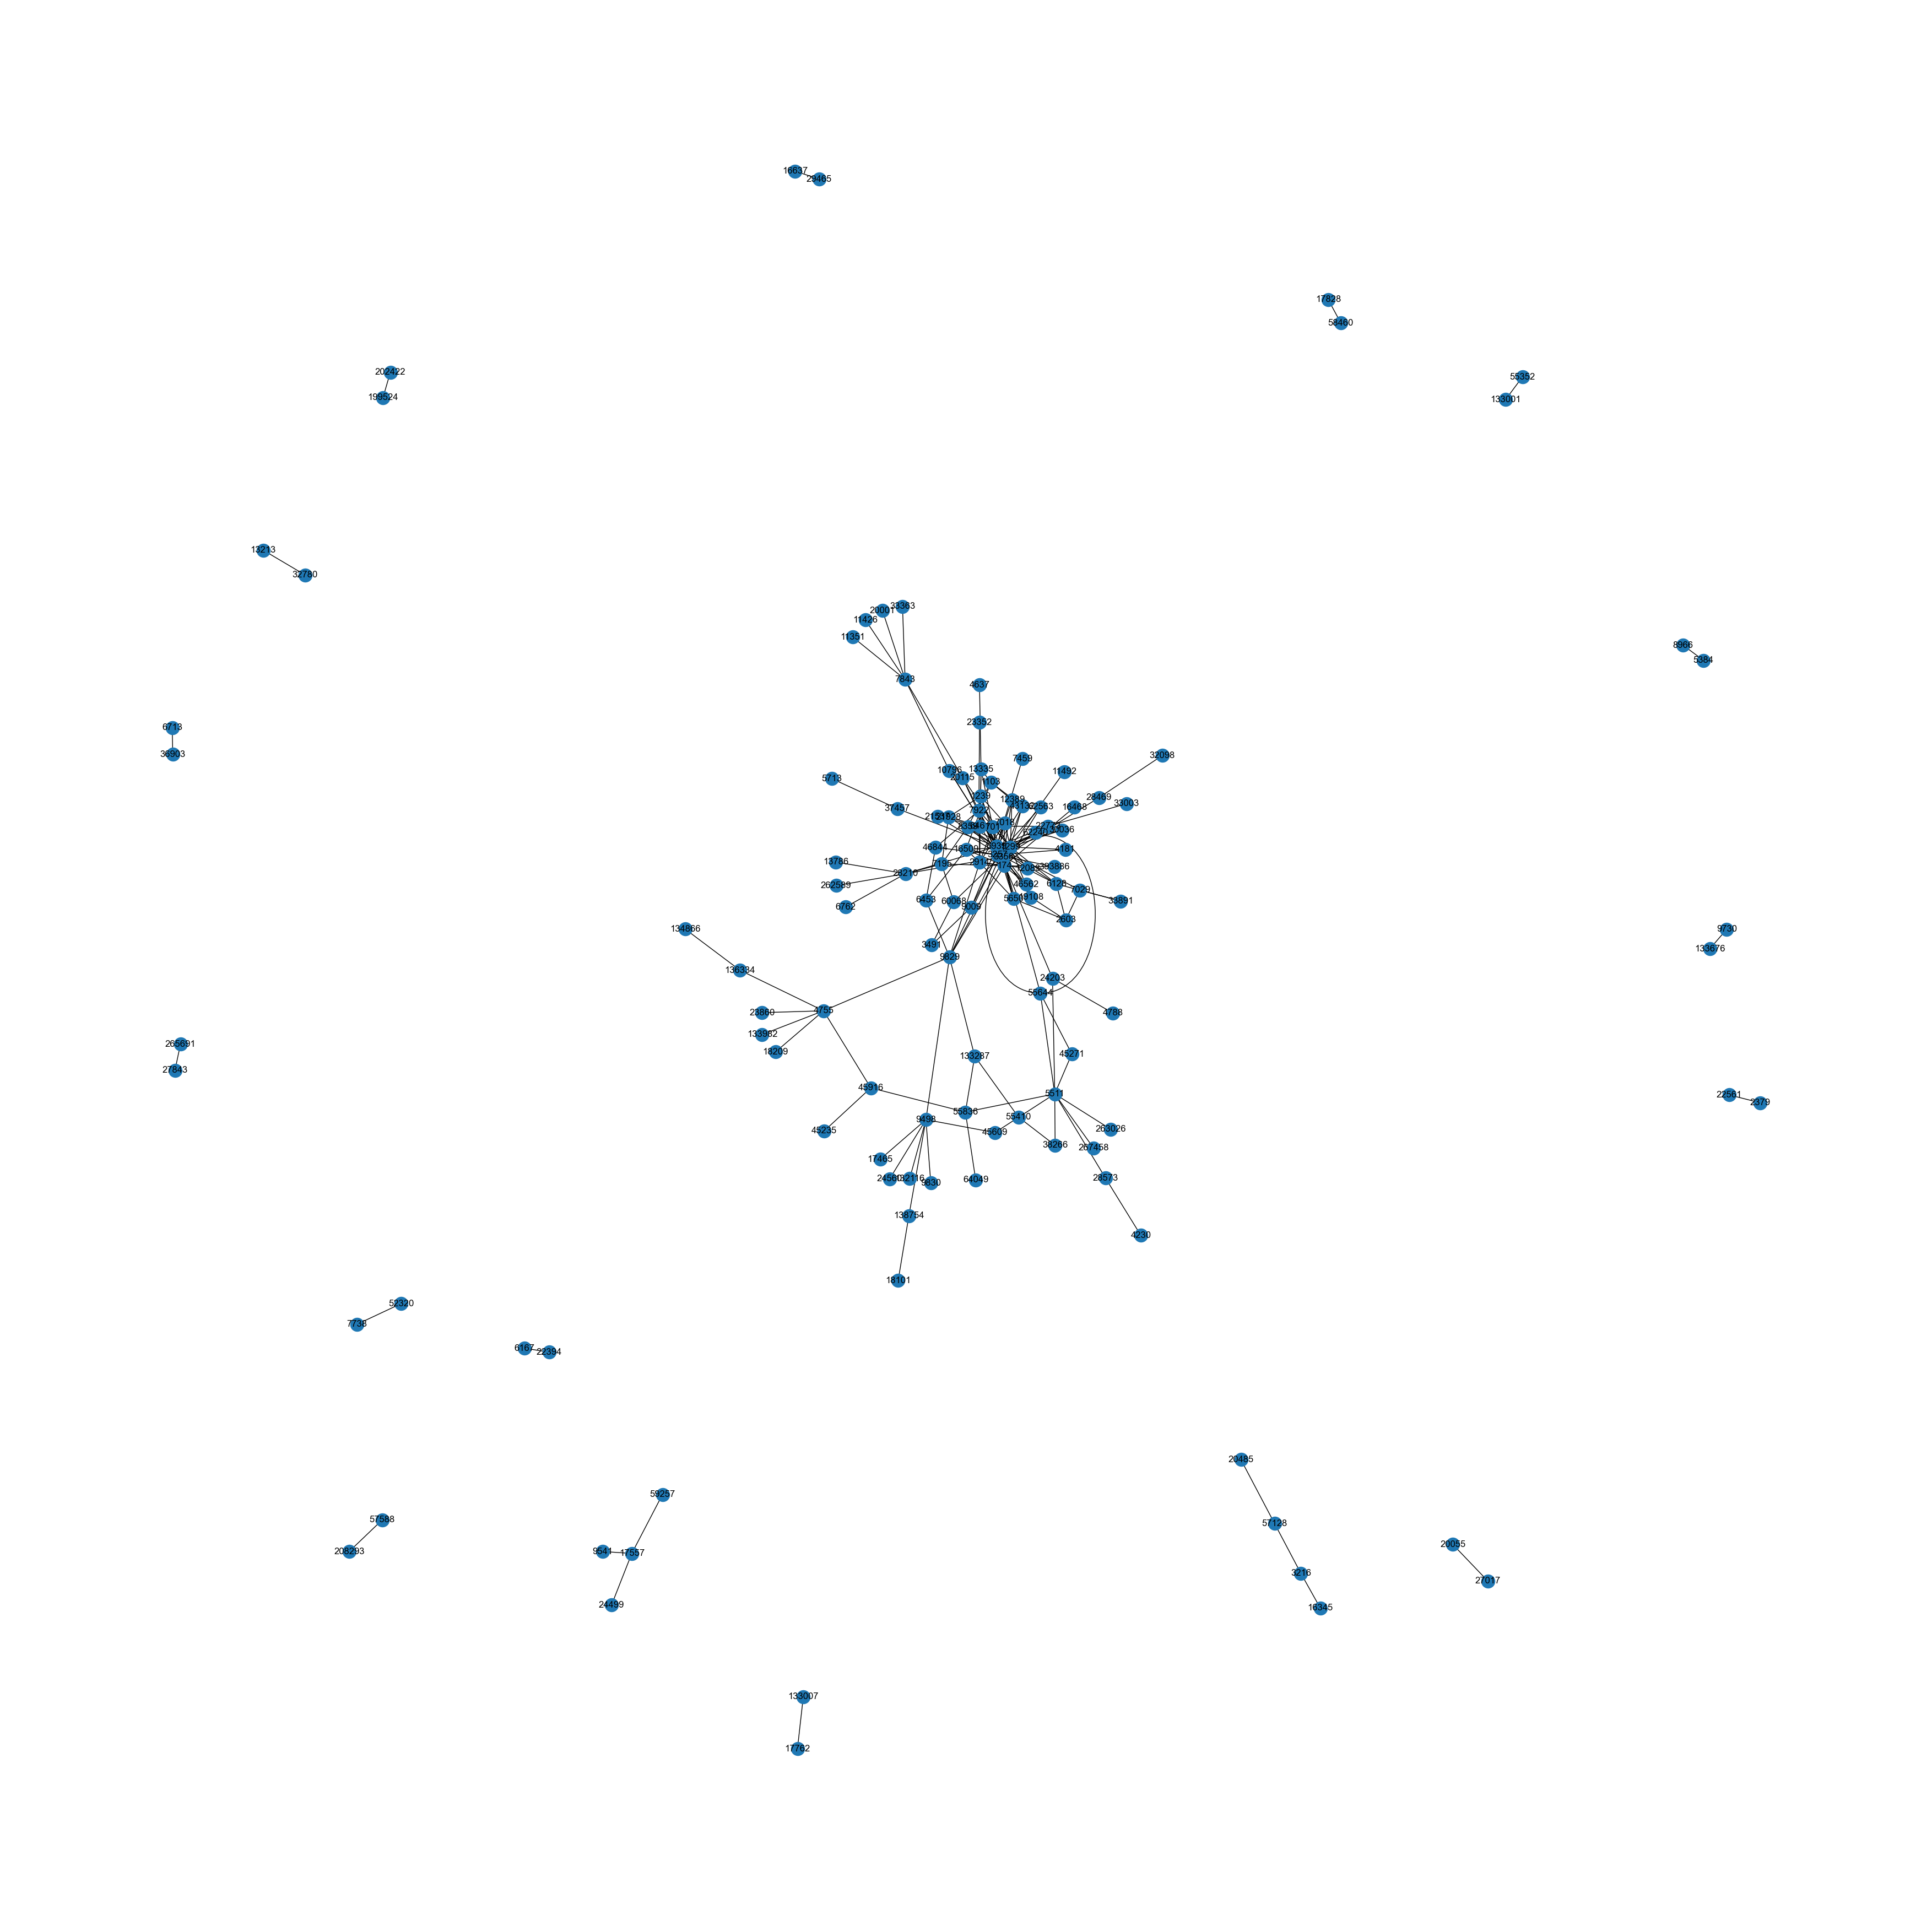

In [67]:
# NetworkX
import networkx as nx
G = nx.Graph()
G = nx.from_pandas_edgelist(df_25_percentile, 'ASN', 'AS Peers')

fig, ax = plt.subplots(figsize=(45,45))
#nx.draw_shell(G, with_labels=True)
nx.draw_spring(G, with_labels=True)

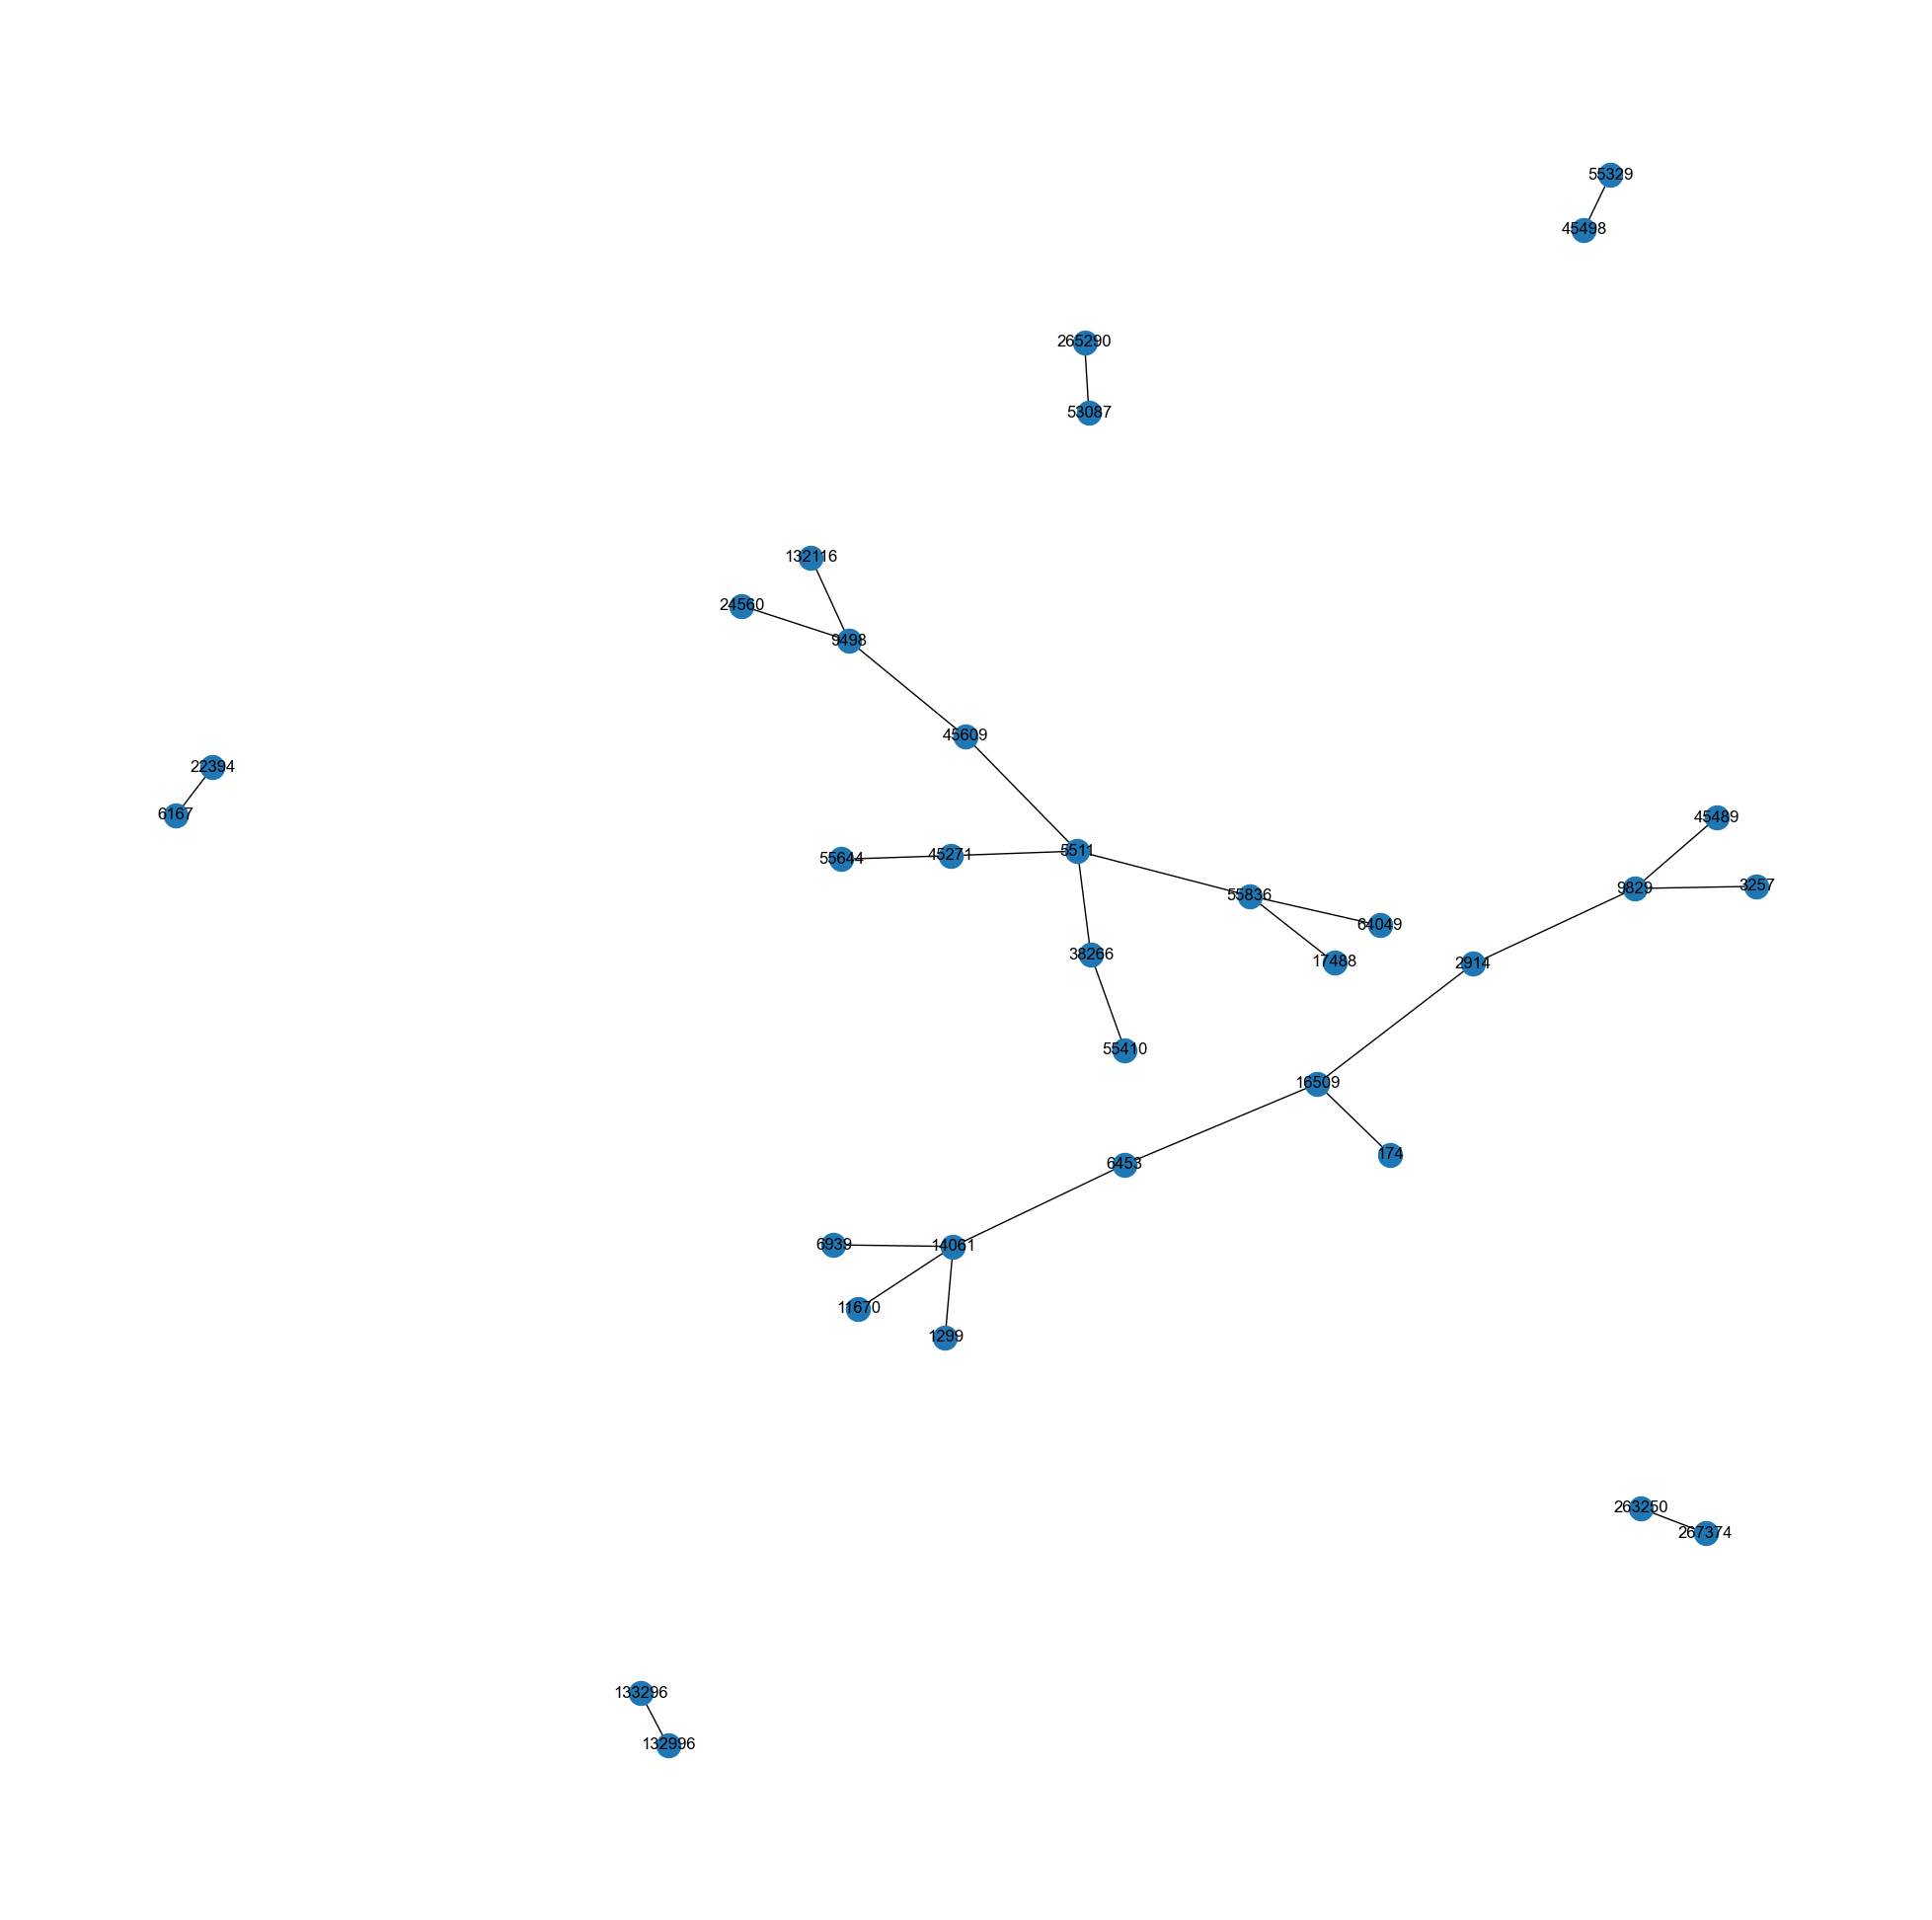

In [37]:
# NetworkX
G = nx.Graph()
G = nx.from_pandas_edgelist(df_50_percentile, 'ASN', 'AS Peers')

fig, ax = plt.subplots(figsize=(25,25))
nx.draw_spring(G, with_labels=True)

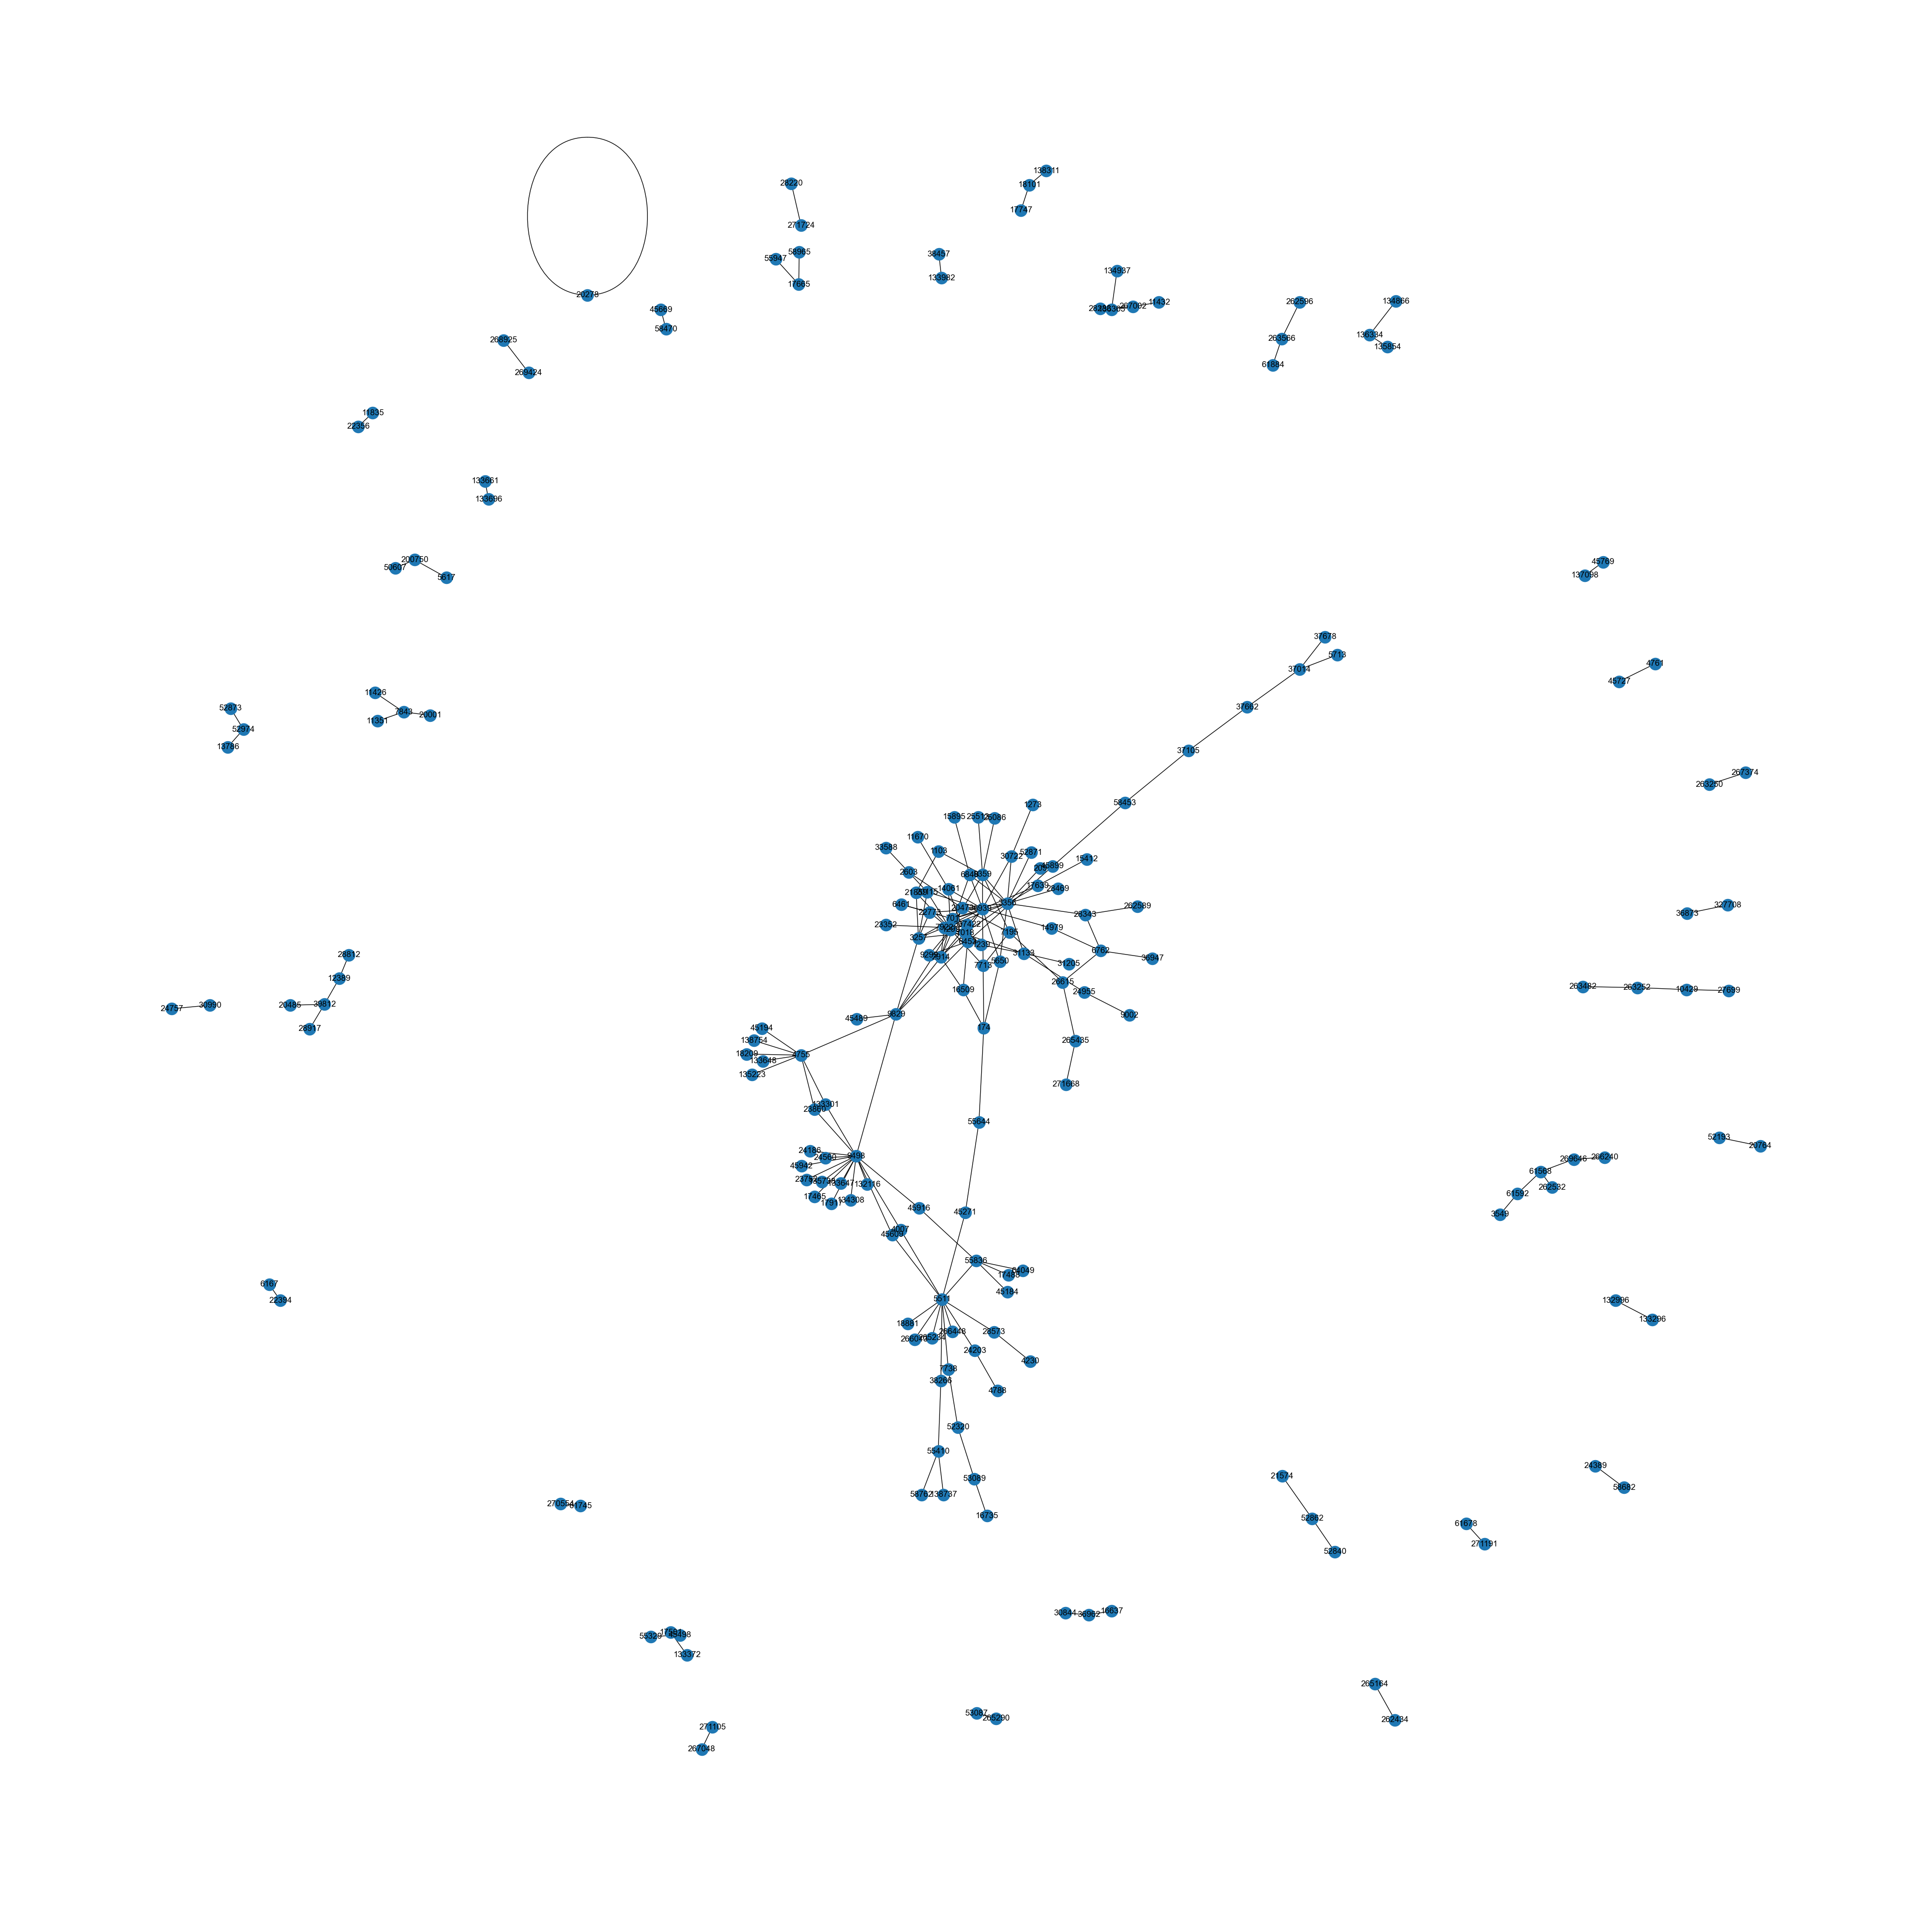

In [34]:
# NetworkX
G = nx.Graph()
G = nx.from_pandas_edgelist(df_iqr_percentile, 'ASN', 'AS Peers')

fig, ax = plt.subplots(figsize=(50,50))
#nx.draw_shell(G, with_labels=True)
nx.draw_spring(G, with_labels=True)

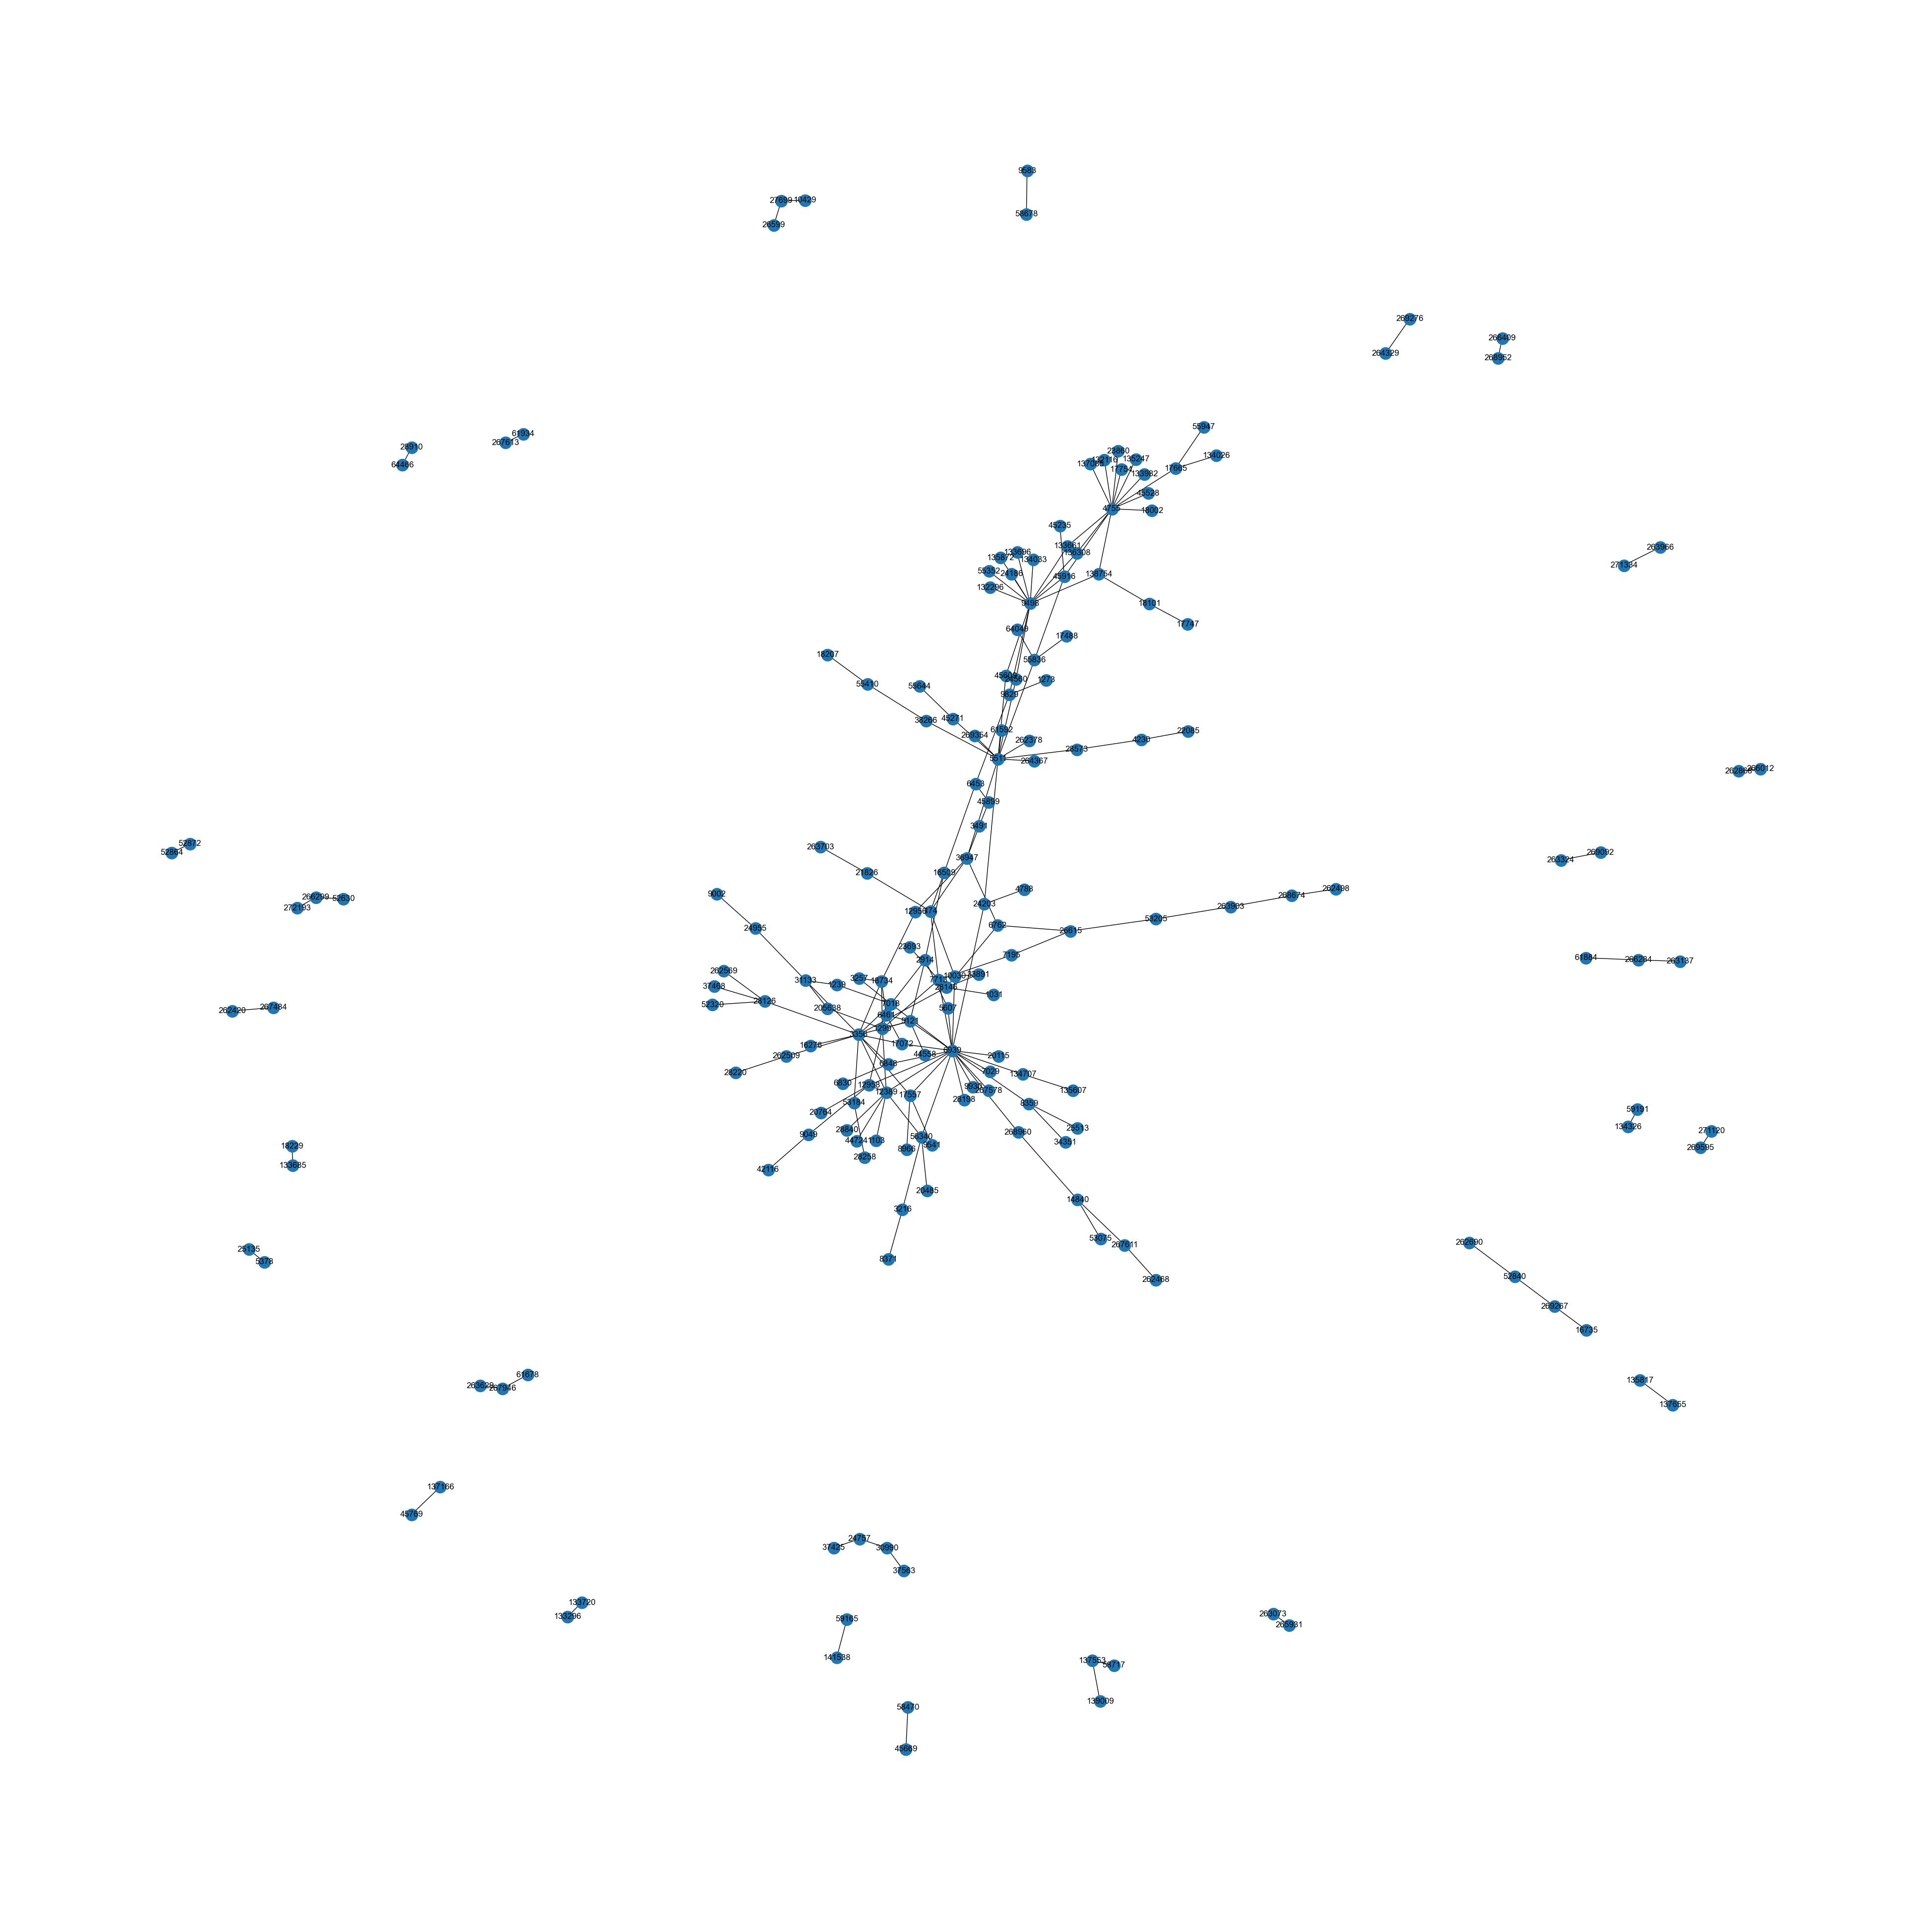

In [36]:
# NetworkX
G = nx.Graph()
G = nx.from_pandas_edgelist(df_75_percentile, 'ASN', 'AS Peers')

fig, ax = plt.subplots(figsize=(50,50))
nx.draw_spring(G, with_labels=True)

---
### 6. Inconclusive Conclusion(s)

I'm going to list a few other areas of questioning that could be pursued, however at this time I would prefer to move on and apply data enrichment(DE) to other data sets that I have.

1. Determine ASN Peers Mapping

Initially the hypothesis here was to determine if there was a linked relationship between the ASN that had the highest source IP address count and subsequent peering relationships. Some of this is answered in the information below as ASN 55836 has the highest prefix count however only a neighbor count of (6). Looking at ASN 4755 which has a neighbor count of (20) but does not have the highest source IP address count. This could be understood to show that the number of peers is not related to the source IP address entries you have or the amount of traffic you send. If you think in terms of tiers it wouldn't be unexpected that a Tier 1 carrier has less peering relationships as they could be the main backbone for other providers and located in a majority of peering locations making network traversal appear across a single network entity.

```
G.degree('55836')
6
```

```
G.degree('4755')
20
```


2. Explore the network relationships further.

The "by RIR" split made the large amount of data easier to work with and it would be useful to continue network analysis with it. A new set of RIR data frames could be created by adding up ip_counts by BGP prefix, allowing the count to be a weight on the connecting edge between ASN's. It is possible that this would easily highlight as specific ASN or set of ASN's with large ip counts going upstream.

3. Generate output data sets

Working through building out subsets of the initial data frame it would be useful to write the new data sets out for isolated review later on.

4. Generate actionable output

As part of exploring the data set(s) we are looking to understand the flow of the network at that specific time. Ideally this would include producing a top percentile list of problematic prefixes, ASN's, Organizations, etc that can be contacted directly to discuss the observed network traffic. This list or table of data would be used to query PCAP or other recorded network flow data to present in abuse reports. Future analysis could take into account certain peering arrangements between networks and apply some inference based on previous observations.

---
#### Example NetworkX Analysis for APNIC

In [98]:
# Create new dataframe and explode AS Peers lists
df_apnic_asn = df_tc.groupby('RIR').get_group('APNIC')
df_apnic_asn = df_apnic_asn.explode('AS Peers', ignore_index=False)

In [99]:
df_apnic_asn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1691 entries, 1 to 1944
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ip_count         1691 non-null   int64 
 1   src_ip           1691 non-null   object
 2   ASN              1691 non-null   object
 3   BGP Prefix       1691 non-null   object
 4   Country Code     1691 non-null   object
 5   RIR              1691 non-null   object
 6   Allocation Date  1691 non-null   object
 7   AS Description   1691 non-null   object
 8   AS Peers         1691 non-null   object
dtypes: int64(1), object(8)
memory usage: 132.1+ KB


In [100]:
df_apnic_asn.head(35)

ip_count           src_ip     ASN        BGP Prefix Country Code    RIR   
1          1     103.100.4.46  132116    103.100.4.0/24           IN  APNIC  \
2          1  103.155.210.207  133007  103.155.210.0/24           IN  APNIC   
3          1     103.39.30.30  134866    103.39.30.0/24           IN  APNIC   
4          1    103.86.19.113   45916    103.86.19.0/24           IN  APNIC   
4          1    103.86.19.113   45916    103.86.19.0/24           IN  APNIC   
6          1   106.204.132.70   45609  106.204.128.0/18           IN  APNIC   
7          1  106.204.152.180   45609  106.204.128.0/18           IN  APNIC   
8          1   106.205.159.99   45609  106.205.128.0/18           IN  APNIC   
9          1    106.205.236.6   45609  106.205.224.0/20           IN  APNIC   
10         1  106.208.154.226   45609  106.208.152.0/22           IN  APNIC   
11         1  106.208.224.215   45609  106.208.224.0/19           IN  APNIC   
12         1   106.210.98.204   45609    106.210.0.0/17           IN  APNIC   
13         1   106.211.38.179   45609   106.211.32.0/20           IN  APNIC   
14         1  106.217.153.244   45609  106.217.128.0/19           IN  APNIC   
15         1   106.220.104.19   45609  106.220.104.0/21           IN  APNIC   
16         1  106.220.249.200   45609  106.220.240.0/20           IN  APNIC   
17         1   106.220.96.106   45609   106.220.96.0/21           IN  APNIC   
18         1  106.223.182.161   45609  106.223.176.0/20           IN  APNIC   
19         1   106.223.27.233   45609    106.223.0.0/17           IN  APNIC   
20         1     106.66.14.75   45271    106.66.14.0/24           IN  APNIC   
21         1     106.76.1.113   45271     106.76.1.0/24           IN  APNIC   
22         1   106.76.208.199   45271   106.76.208.0/24           IN  APNIC   
23         1   106.76.249.200   45271   106.76.249.0/24           IN  APNIC   
24         1     106.76.69.66   45271    106.76.69.0/24           IN  APNIC   
25         1    106.76.77.212   45271    106.76.77.0/24           IN  APNIC   
26         1   106.79.203.234   45271   106.79.203.0/24           IN  APNIC   
27         1   106.79.203.236   45271   106.79.203.0/24           IN  APNIC   
28         1   106.79.203.245   45271   106.79.203.0/24           IN  APNIC   
29         1    106.79.203.32   45271   106.79.203.0/24           IN  APNIC   
30         1    106.79.203.68   45271   106.79.203.0/24           IN  APNIC   
31         1     106.79.203.8   45271   106.79.203.0/24           IN  APNIC   
32         1   111.119.187.47   59257  111.119.184.0/21           PK  APNIC   
33         1   112.79.108.167   38266   112.79.108.0/24           IN  APNIC   
34         1   112.79.123.120   38266   112.79.123.0/24           IN  APNIC   
35         1   114.31.137.206   38266   114.31.136.0/21           IN  APNIC   

   Allocation Date                                     AS Description AS Peers  
1       2017-08-31              ANINETWORK-IN Ani Network Pvt Ltd, IN     9498  
2       2020-09-16              UCN-AS UCN CABLE NETWORK PVT. LTD, IN    17762  
3       2014-09-16                           SSCN-AS Sscn Pvt Ltd, IN   136334  
4       2017-02-16            GTPL-AS-AP Gujarat Telelink Pvt Ltd, IN     4755  
4       2017-02-16            GTPL-AS-AP Gujarat Telelink Pvt Ltd, IN    55836  
6       2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
7       2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
8       2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
9       2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
10      2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
11      2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
12      2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
13      2011-03-17  BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...     9498  
14      2011-03-17  BHART

---
#### Graph new data frame APNIC

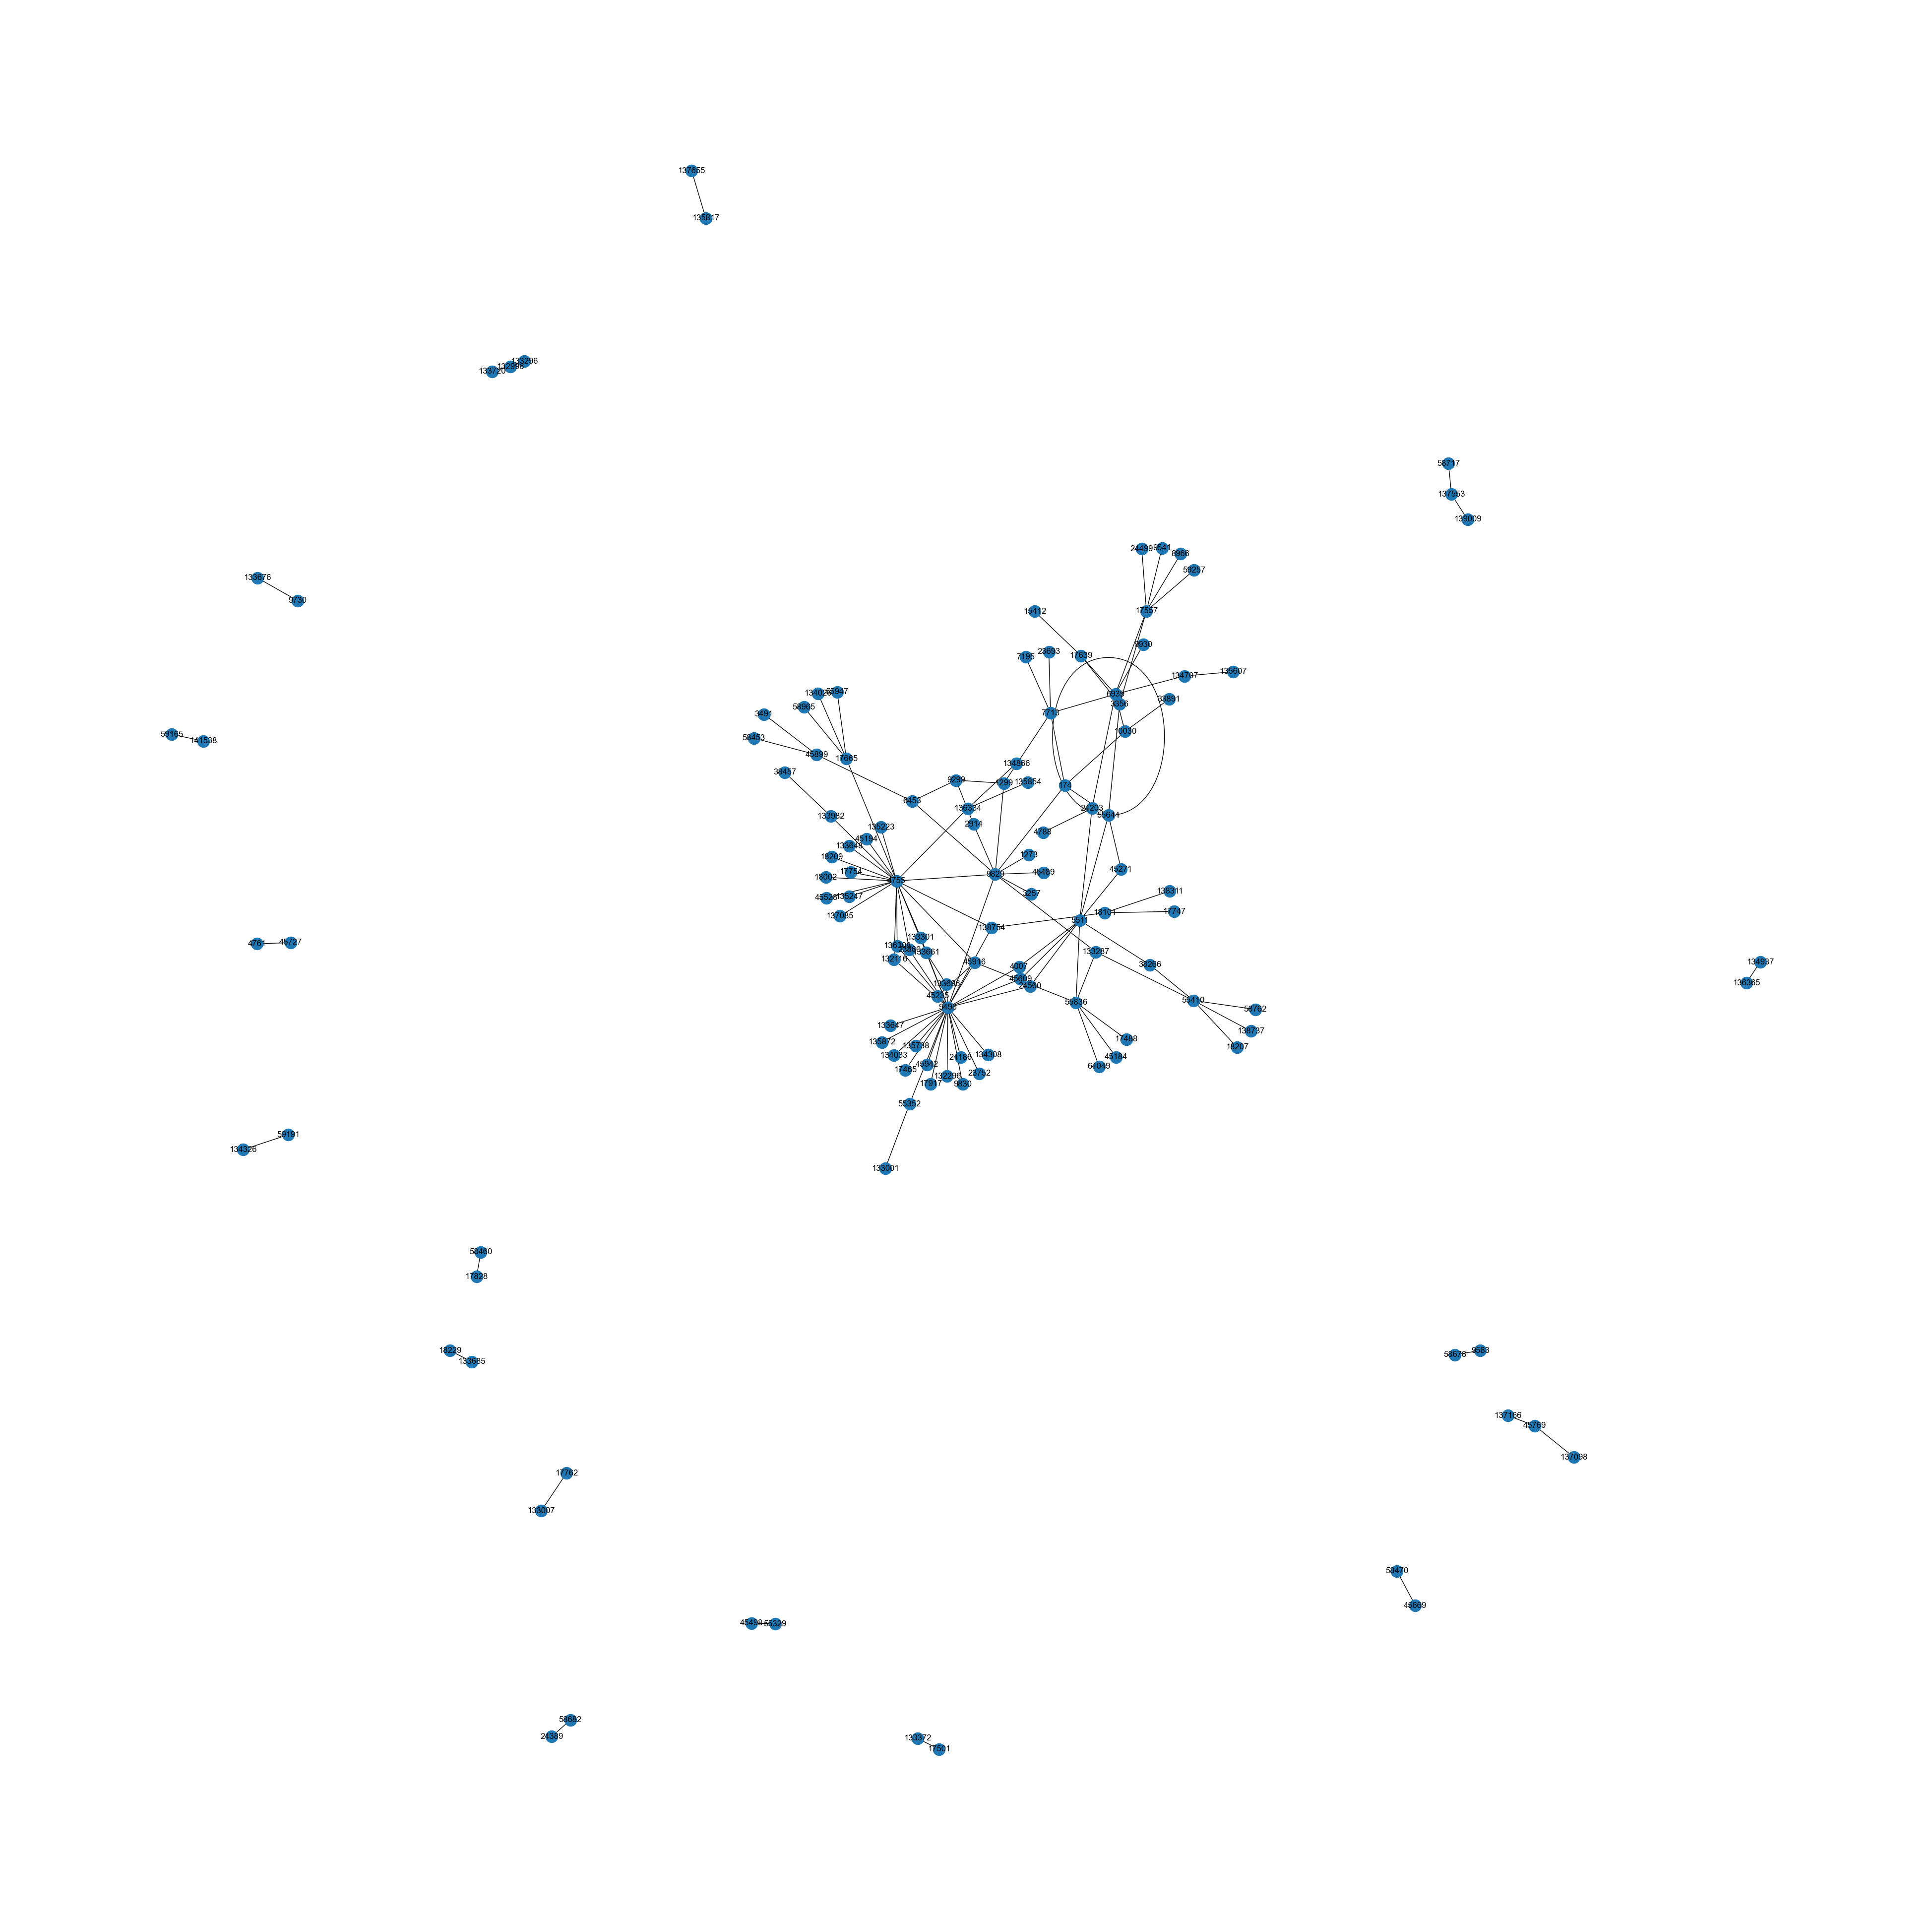

In [101]:
# NetworkX
G = nx.DiGraph()
G = nx.from_pandas_edgelist(df_apnic_asn, 'ASN', 'AS Peers')

fig, ax = plt.subplots(figsize=(50,50))
nx.draw_spring(G, with_labels=True)

---
#### Review graph stats

In [102]:
G.number_of_edges()

135

In [103]:
G.number_of_nodes()

130

In [104]:
G.adj

AdjacencyView({'132116': {'9498': {}, '4755': {}}, '9498': {'132116': {}, '45609': {}, '24560': {}, '17465': {}, '9829': {}, '138754': {}, '9830': {}, '23860': {}, '45916': {}, '24186': {}, '17917': {}, '4007': {}, '133301': {}, '135738': {}, '134308': {}, '45942': {}, '23752': {}, '133647': {}, '132296': {}, '136308': {}, '133661': {}, '133696': {}, '134033': {}, '135872': {}, '55352': {}}, '133007': {'17762': {}}, '17762': {'133007': {}}, '134866': {'136334': {}}, '136334': {'134866': {}, '4755': {}, '135854': {}}, '45916': {'4755': {}, '55836': {}, '45235': {}, '9498': {}}, '4755': {'45916': {}, '9829': {}, '18209': {}, '133982': {}, '136334': {}, '23860': {}, '138754': {}, '135223': {}, '45194': {}, '133301': {}, '133648': {}, '17665': {}, '133661': {}, '136308': {}, '137085': {}, '18002': {}, '135247': {}, '132116': {}, '17754': {}, '45528': {}}, '55836': {'45916': {}, '64049': {}, '5511': {}, '133287': {}, '17488': {}, '45184': {}}, '45609': {'9498': {}, '5511': {}}, '45271': {'5

In [105]:
G.degree

DegreeView({'132116': 2, '9498': 25, '133007': 1, '17762': 1, '134866': 1, '136334': 3, '45916': 4, '4755': 20, '55836': 6, '45609': 2, '45271': 2, '55644': 6, '59257': 1, '17557': 6, '38266': 2, '55410': 5, '9829': 10, '6453': 3, '45235': 1, '24560': 2, '18209': 1, '64049': 1, '133287': 3, '17465': 1, '5511': 8, '3356': 3, '58460': 1, '17828': 1, '133676': 1, '9730': 1, '133982': 2, '24203': 3, '4788': 1, '6939': 7, '1299': 3, '2914': 2, '3257': 1, '133001': 1, '55352': 2, '138754': 3, '18101': 3, '174': 4, '23860': 2, '9830': 1, '9541': 1, '24499': 1, '45489': 1, '135854': 1, '137098': 1, '45769': 2, '24186': 1, '17639': 3, '15412': 1, '7713': 5, '7195': 1, '58965': 1, '17665': 4, '133696': 2, '133661': 3, '45727': 1, '4761': 1, '17917': 1, '135223': 1, '45194': 1, '4007': 2, '133301': 2, '132996': 1, '133296': 2, '17488': 1, '45498': 1, '55329': 1, '138737': 1, '138311': 1, '136365': 1, '134937': 1, '17501': 1, '133372': 1, '135738': 1, '134308': 1, '45942': 1, '9299': 3, '38457': 1

In [106]:
G.nodes

NodeView(('132116', '9498', '133007', '17762', '134866', '136334', '45916', '4755', '55836', '45609', '45271', '55644', '59257', '17557', '38266', '55410', '9829', '6453', '45235', '24560', '18209', '64049', '133287', '17465', '5511', '3356', '58460', '17828', '133676', '9730', '133982', '24203', '4788', '6939', '1299', '2914', '3257', '133001', '55352', '138754', '18101', '174', '23860', '9830', '9541', '24499', '45489', '135854', '137098', '45769', '24186', '17639', '15412', '7713', '7195', '58965', '17665', '133696', '133661', '45727', '4761', '17917', '135223', '45194', '4007', '133301', '132996', '133296', '17488', '45498', '55329', '138737', '138311', '136365', '134937', '17501', '133372', '135738', '134308', '45942', '9299', '38457', '24389', '58682', '55947', '23752', '45899', '58453', '58762', '133647', '45669', '58470', '45184', '133648', '17747', '132296', '1273', '134326', '59191', '18207', '137166', '136308', '137085', '133685', '18229', '18002', '135247', '141538', '59165

In [107]:
G.edges

EdgeView([('132116', '9498'), ('132116', '4755'), ('9498', '45609'), ('9498', '24560'), ('9498', '17465'), ('9498', '9829'), ('9498', '138754'), ('9498', '9830'), ('9498', '23860'), ('9498', '45916'), ('9498', '24186'), ('9498', '17917'), ('9498', '4007'), ('9498', '133301'), ('9498', '135738'), ('9498', '134308'), ('9498', '45942'), ('9498', '23752'), ('9498', '133647'), ('9498', '132296'), ('9498', '136308'), ('9498', '133661'), ('9498', '133696'), ('9498', '134033'), ('9498', '135872'), ('9498', '55352'), ('133007', '17762'), ('134866', '136334'), ('136334', '4755'), ('136334', '135854'), ('45916', '4755'), ('45916', '55836'), ('45916', '45235'), ('4755', '9829'), ('4755', '18209'), ('4755', '133982'), ('4755', '23860'), ('4755', '138754'), ('4755', '135223'), ('4755', '45194'), ('4755', '133301'), ('4755', '133648'), ('4755', '17665'), ('4755', '133661'), ('4755', '136308'), ('4755', '137085'), ('4755', '18002'), ('4755', '135247'), ('4755', '17754'), ('4755', '45528'), ('55836', '

In [108]:
G.degree('55836')

6

In [109]:
G.degree('4755')

20

In [110]:
nx.number_of_selfloops(G)

1

In [111]:
for n in G.neighbors('55836'):
    print(n)

45916
64049
5511
133287
17488
45184


In [112]:
# https://www.clear.rice.edu/comp200/12spring/notes/comp140/lab4/
nx.degree_histogram(G)

[0,
 87,
 17,
 13,
 3,
 2,
 3,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1]

In [113]:
for cc in nx.connected_components(G):
    print(cc)

{'24203', '132296', '135607', '1299', '45235', '55352', '17557', '134026', '3257', '7195', '8966', '55644', '17917', '18101', '134866', '17665', '17747', '55836', '133001', '3356', '23693', '138754', '55947', '18207', '45916', '133982', '23752', '4788', '59257', '9930', '4007', '23860', '38457', '136334', '24560', '9541', '17488', '6939', '7713', '174', '17465', '4755', '45194', '133648', '9829', '133287', '5511', '135854', '138311', '133696', '137085', '24499', '38266', '135223', '135247', '55410', '133301', '33891', '45609', '1273', '45899', '133647', '134308', '132116', '135872', '58453', '136308', '45528', '17754', '45489', '58965', '138737', '58762', '135738', '6453', '24186', '64049', '2914', '45942', '18002', '9830', '3491', '17639', '9299', '18209', '45271', '9498', '10030', '134707', '133661', '15412', '45184', '134033'}
{'133007', '17762'}
{'17828', '58460'}
{'9730', '133676'}
{'45769', '137166', '137098'}
{'45727', '4761'}
{'133296', '133720', '132996'}
{'55329', '45498'}
{'

---
<h4><span style='color:#8E5609;background:white'>www.threatlocus.com &copy</span></h4>

Copyright (C) 2022 www.threatlocus.com / Stephen Scally

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

---